In [4]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [5]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/share/fonts: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/urw-base35: caching, new cache contents: 35 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/droid: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts

In [6]:
cluster_data = pd.read_csv('../data/total_cluster.csv', index_col=0)
cluster_diff = pd.read_csv('../data/cluster_difference.csv', index_col=0)

cluster_diff.head()

,20191_cluster,20192_cluster,20193_cluster,20194_cluster,20201_cluster,20202_cluster,20203_cluster,20204_cluster,20211_cluster,20212_cluster,...,20214_cluster,20221_cluster,20222_cluster,20223_cluster,20224_cluster,20231_cluster,20232_cluster,20233_cluster,20234_cluster,상권
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,배화여자대학교(박노수미술관)
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,세종마을음식문화거리(금천교시장)
2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,통인시장
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,동묘시장(동묘벼룩시장)
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,동대문문구완구거리(동대문문구완구시장)


# Cluster EDA
1. 매출 우선 분석에 대한 근거는 다 가지고 있음
2. 매출에 대한 분석을 우선으로 진행할꺼고
3. 매출에 대한 클러스터 특성을 찾아내면 지난 EDA의 가설을 검증하면서 데이터를 확인할꺼임

In [7]:
# 최종의 최종의 데이터프레임 건들지마셈
df = pd.merge(cluster_data, cluster_diff, left_on='상권', right_on='상권')

In [8]:
data_column = df.columns.tolist()
mask_cluster = [col for col in data_column if 'cluster' in str(col)]
mask_month_price = [col for col in data_column if '당월매출금액' in str(col)]
mask_month_count = [col for col in data_column if '당월매출건수' in str(col)]

In [9]:
month_price_df = df[['상권'] + mask_month_price + mask_cluster]
month_count_df = df[['상권'] + mask_month_count + mask_cluster]

아까 변환할떄
- 0 : 모르겠는 지역
- 1 : 젠트 예상지역
- 2 : 비젠트 예상지역
- 3 : 일반상권 예상지역

## 이런식으로 진행할꺼임
1. cluster 변화를 알아야함 그래야지 좀 일이 쉬워짐
2. 2019 1분기랑 2023 4분기와 비교해서 변화량을 볼꺼임(2019년 1분기에 대해서 전체 행의 숫자를 count)

In [10]:
# 결과를 저장할 리스트
counts = []

# 각 행에 대해 반복
for i in range(len(cluster_diff)):
  # 현재 행의 첫 번째 값
  first_value = cluster_diff.iloc[i, 0]

  # 해당 행에서 첫 번째 값이 나타나는 횟수 계산
  count = (cluster_diff.iloc[i] == first_value).sum()

  # 결과 저장
  counts.append(count)

# 결과 확인
# 원본 데이터프레임에 새로운 열로 추가할 수도 있습니다
cluster_diff['first_value_count'] = counts
cluster_diff_count = cluster_diff.dropna()

In [11]:
cluster_target_df = cluster_diff_count[cluster_diff_count['first_value_count'] != 20]

In [12]:
target_df = pd.merge(cluster_data, cluster_target_df)

In [13]:
# 우리가 원하는건 매출에 대한 분석이죠?
month_price_df = target_df[['상권'] + mask_month_price + mask_cluster]
month_count_df = target_df[['상권'] + mask_month_count + mask_cluster]

### 당월매출에 대한 금액 EDA

In [14]:
def setting_df(df):
  """
    df : DataFrame
      상권에 전처리 완료하면 실행하기기
  """
  # 젠 -> 비젠
  # 2019년도가 1이면 젠트 -> 비젠
  df_gtong = df[df['20191_cluster'] == 1]
  # 비젠 -> 젠
  # 2019년도가 2면 비젠 -> 젠트
  df_ngtog = df[df['20191_cluster'] == 2]

  return df_gtong, df_ngtog

In [15]:
def diff_visualization(df_fillter):
  """
   df_fiillter : DataFrame
   너가 원하는것만 한 행만 넣어야함   
  """
  df_fillter = df_fillter.set_index(keys='상권')
  want_vis_col = df_fillter.iloc[:, :20]
  target_cluster_diff = df_fillter.iloc[:, 20:]
  target_cluster_diff.columns = want_vis_col.columns.tolist()
  df_fillter = df_fillter.reset_index()

  fig, ax = plt.subplots(figsize=(20, 6))
  ax.set_title(f'{df_fillter.iloc[0,0]}({target_cluster_diff.iloc[0,0]}번 군집)', fontsize=30)
  sns.pointplot(data=want_vis_col, ax=ax, color='blue', label='Point Data')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

  # 두 번째 그래프
  ax2 = ax.twinx()
  sns.barplot(data=target_cluster_diff, ax=ax2, alpha=0.3, color='red', label='Bar Data')
  ax2.set_ylim(0, 3)

  plt.tight_layout()
  plt.show()

In [16]:
# 함수 로드
month_price_gtong, month_price_ngtog = setting_df(month_price_df)

In [ ]:
for site_name in month_price_gtong['상권'].tolist():
  diff_visualization(month_price_gtong[month_price_gtong['상권'] == f'{site_name}'])

#### 결론
- 당월매출에 관해서는 관련이 없다.

### 당월건수에 대한 금액 EDA

In [ ]:
month_count_df = target_df[['상권'] + mask_month_count + mask_cluster]
month_count_gtong, month_count_ngtog = setting_df(month_count_df)
for site_name in month_count_gtong['상권'].tolist():
  diff_visualization(month_count_gtong[month_count_gtong['상권'] == f'{site_name}'])

#### 결론
- 관계없음

### 당월로보면 좀 안될꺼같음(PC1에 대해서 당월보다는 금요일에 로딩값이 큼)
- 내용이 많은 금요일부터 한번보자

In [19]:
[col for col in data_column if '금요일' in str(col)]

['20191금요일유동인구수',
 '20192금요일유동인구수',
 '20193금요일유동인구수',
 '20194금요일유동인구수',
 '20201금요일유동인구수',
 '20202금요일유동인구수',
 '20203금요일유동인구수',
 '20204금요일유동인구수',
 '20211금요일유동인구수',
 '20212금요일유동인구수',
 '20213금요일유동인구수',
 '20214금요일유동인구수',
 '20221금요일유동인구수',
 '20222금요일유동인구수',
 '20223금요일유동인구수',
 '20224금요일유동인구수',
 '20231금요일유동인구수',
 '20232금요일유동인구수',
 '20233금요일유동인구수',
 '20234금요일유동인구수',
 '20191금요일매출금액',
 '20192금요일매출금액',
 '20193금요일매출금액',
 '20194금요일매출금액',
 '20201금요일매출금액',
 '20202금요일매출금액',
 '20203금요일매출금액',
 '20204금요일매출금액',
 '20211금요일매출금액',
 '20212금요일매출금액',
 '20213금요일매출금액',
 '20214금요일매출금액',
 '20221금요일매출금액',
 '20222금요일매출금액',
 '20223금요일매출금액',
 '20224금요일매출금액',
 '20231금요일매출금액',
 '20232금요일매출금액',
 '20233금요일매출금액',
 '20234금요일매출금액',
 '20191금요일매출건수',
 '20192금요일매출건수',
 '20193금요일매출건수',
 '20194금요일매출건수',
 '20201금요일매출건수',
 '20202금요일매출건수',
 '20203금요일매출건수',
 '20204금요일매출건수',
 '20211금요일매출건수',
 '20212금요일매출건수',
 '20213금요일매출건수',
 '20214금요일매출건수',
 '20221금요일매출건수',
 '20222금요일매출건수',
 '20223금요일매출건수',
 '20224금요일매출건수',
 '20231금요일매출건수',
 '20232금요일매

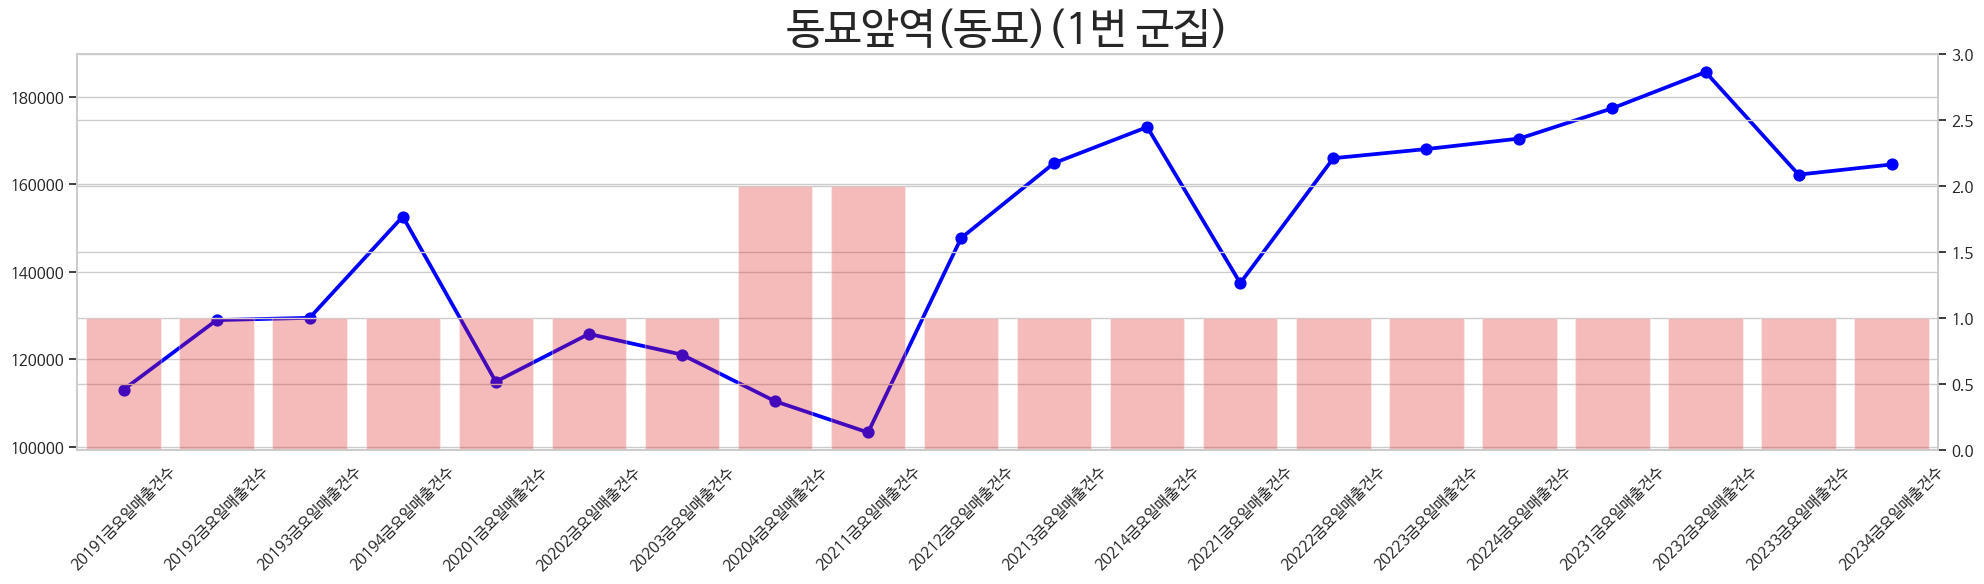

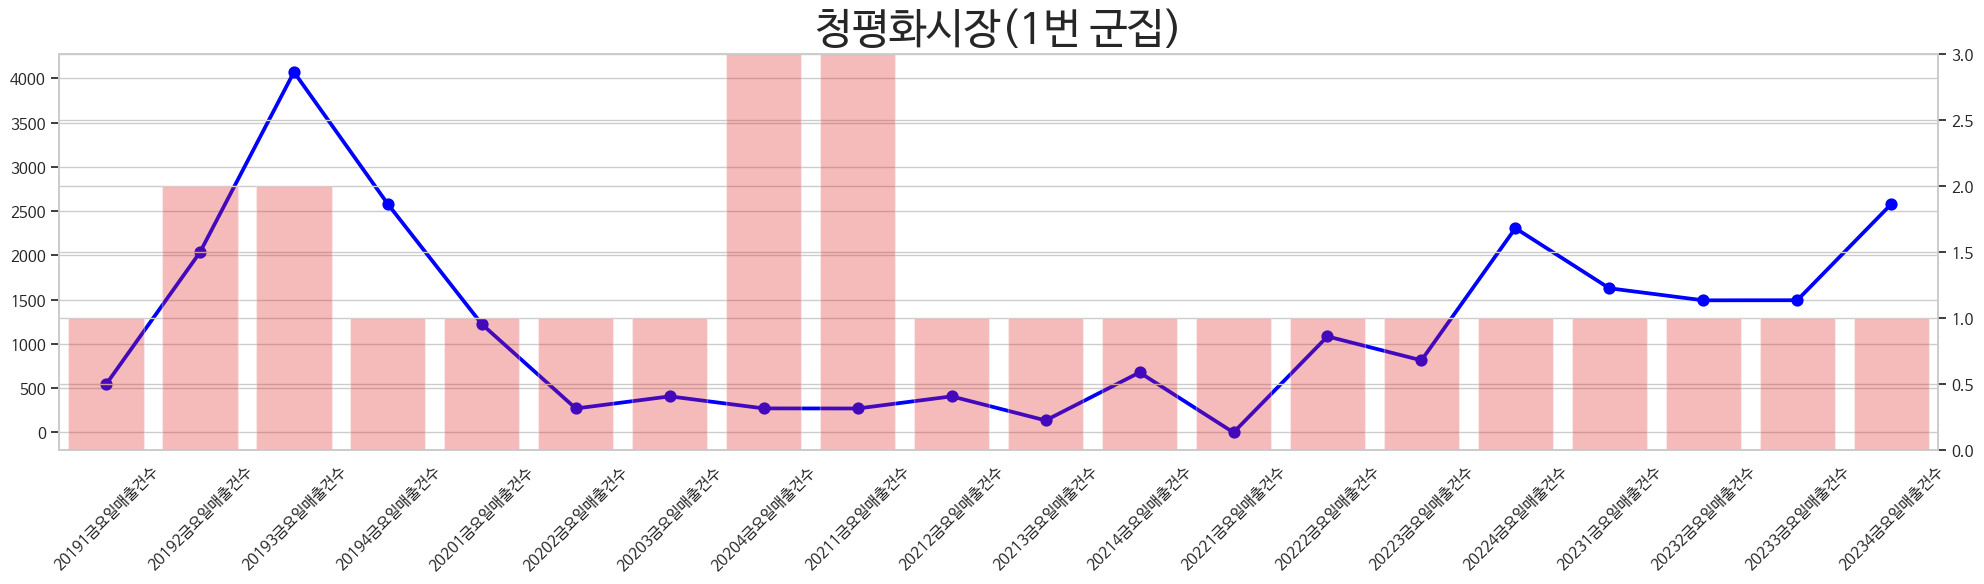

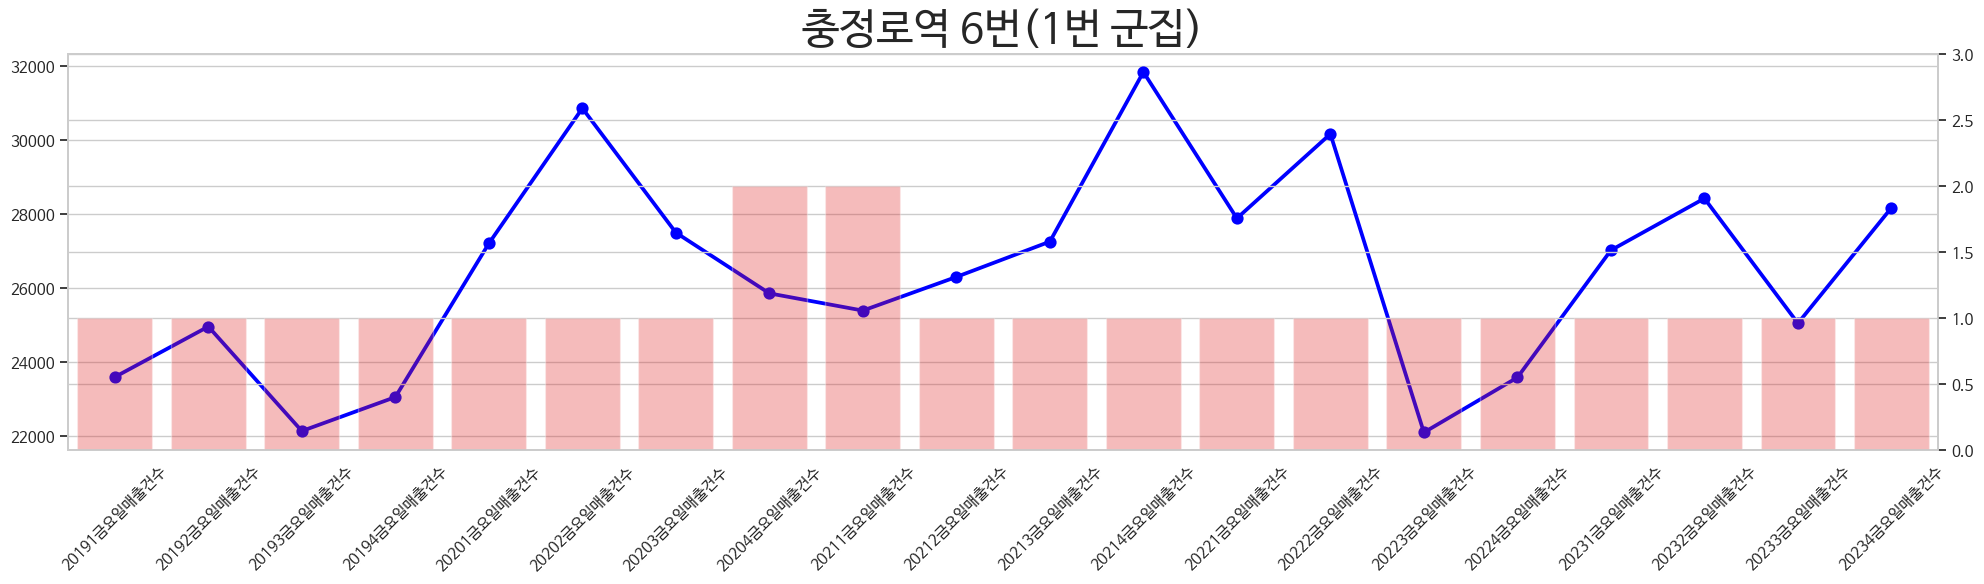

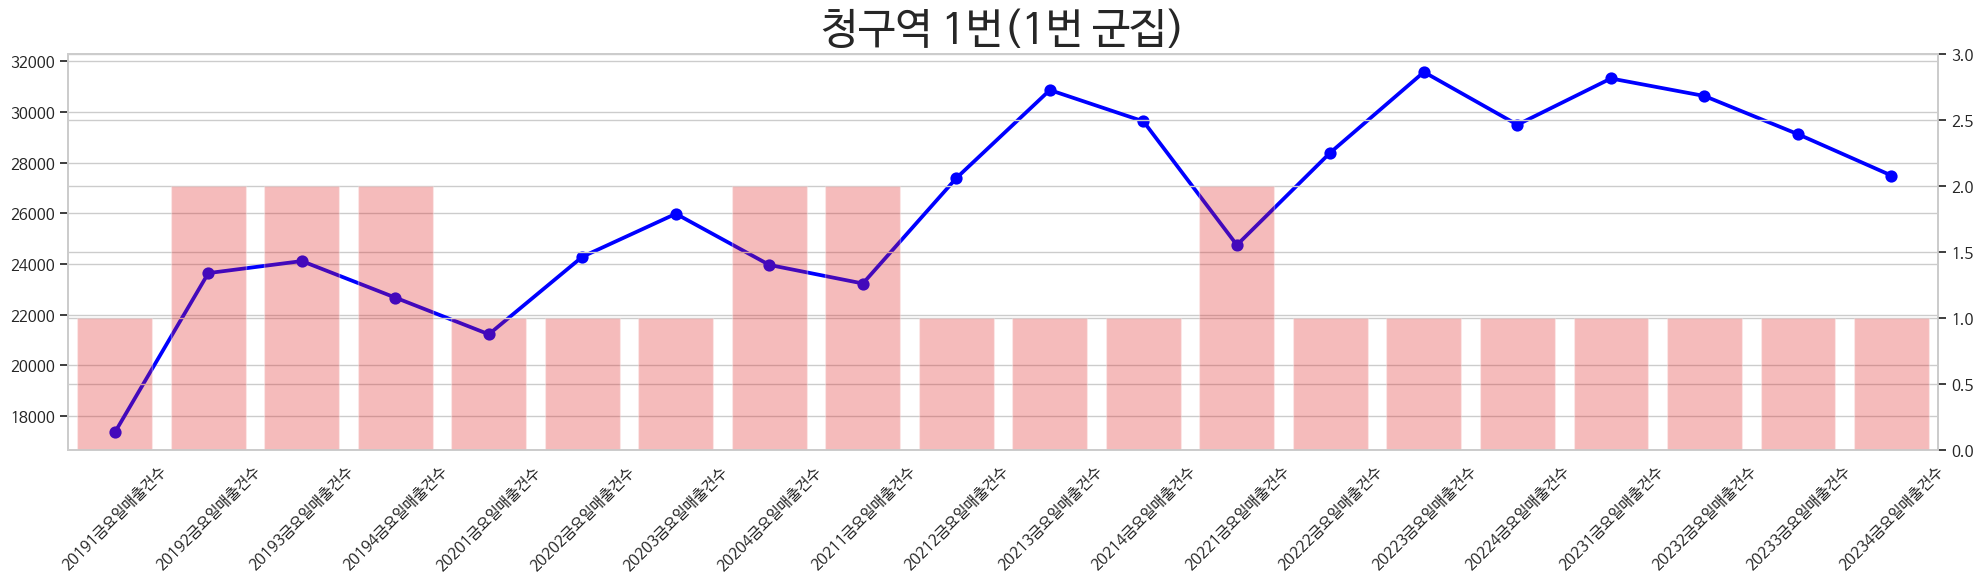

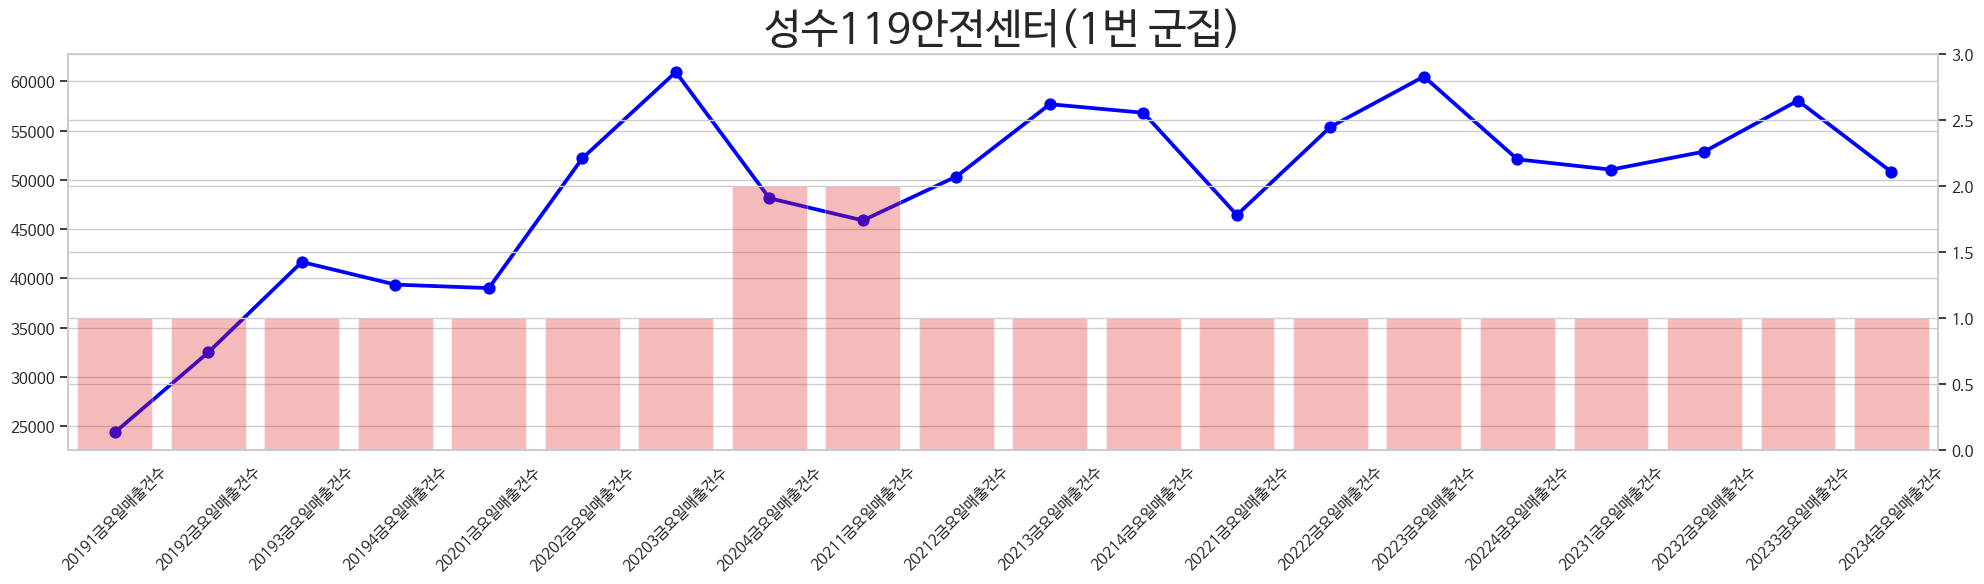

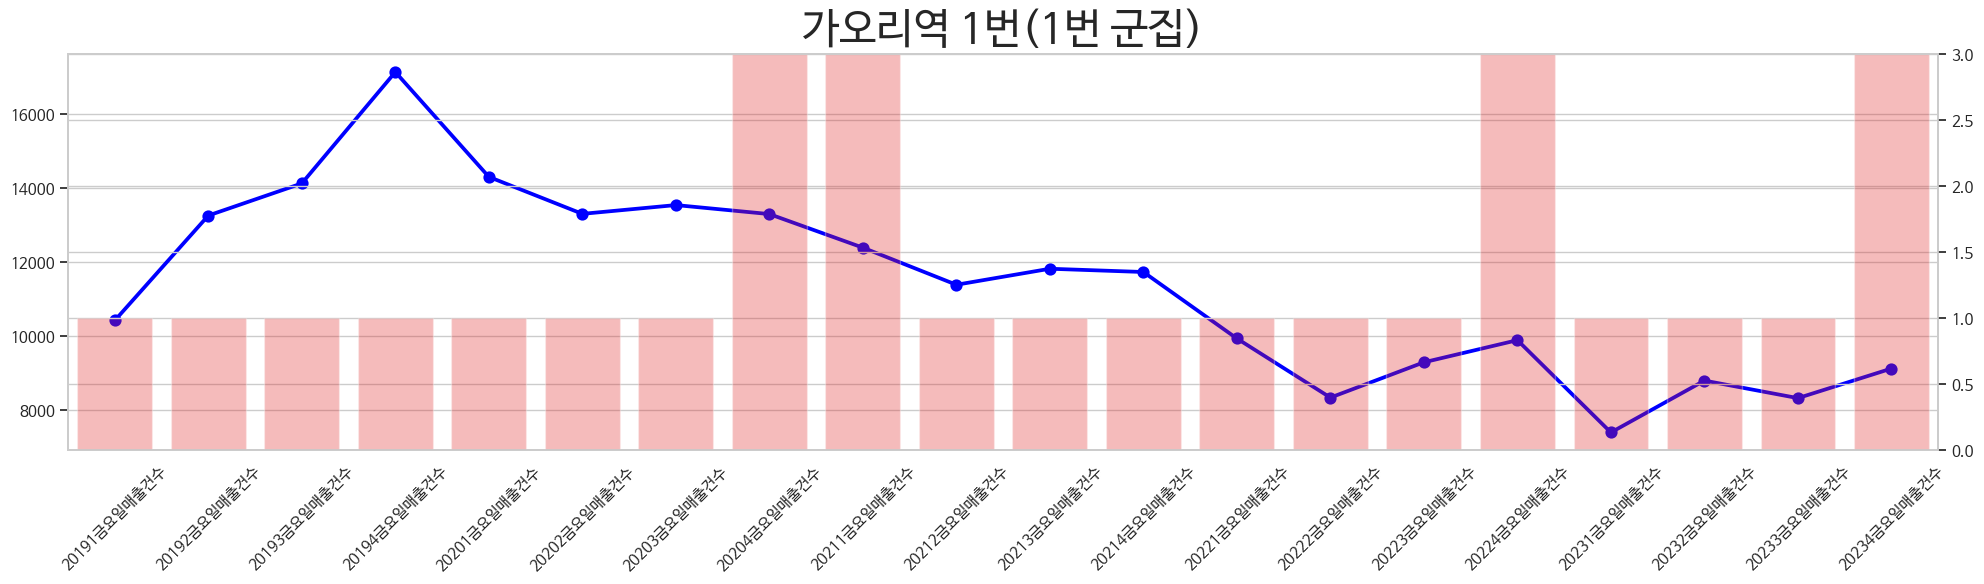

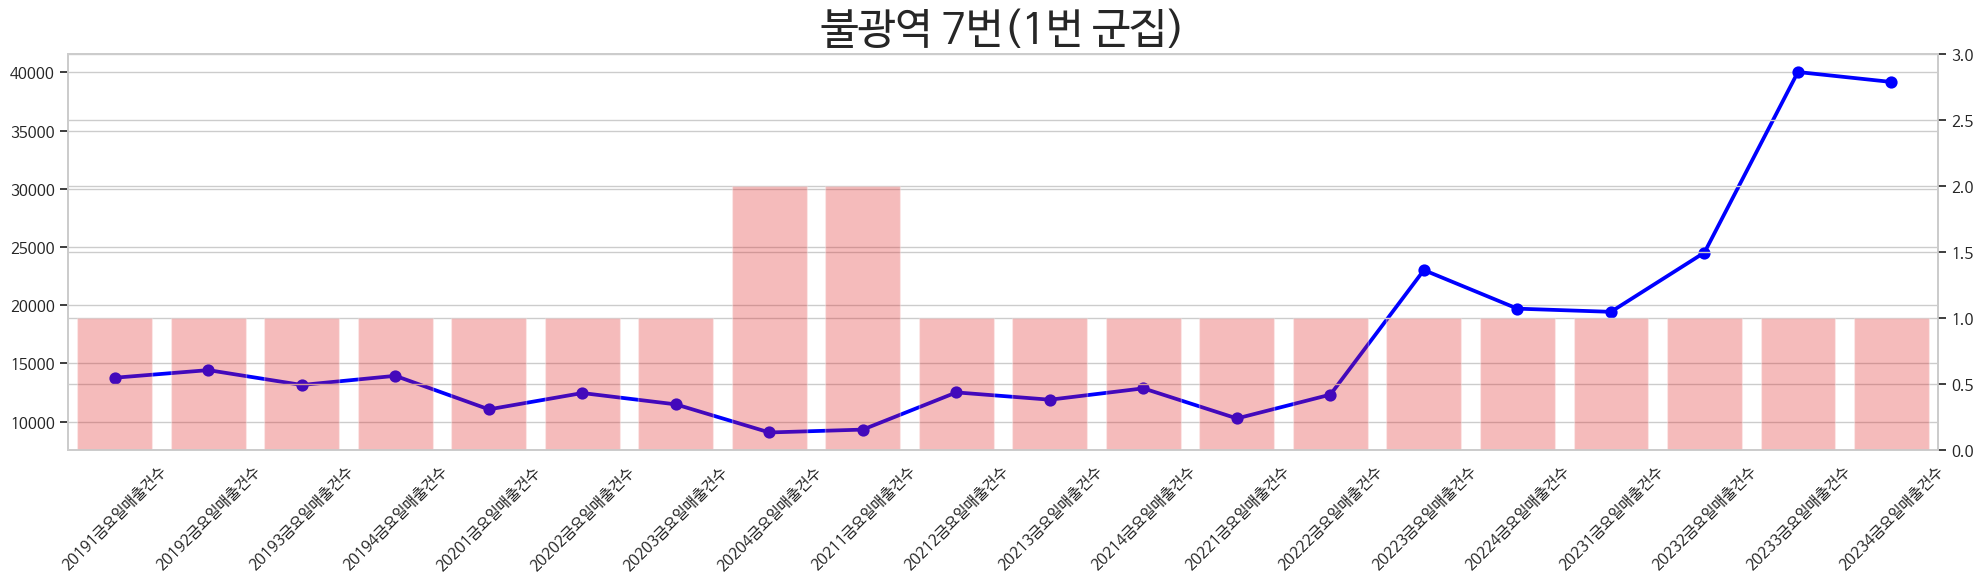

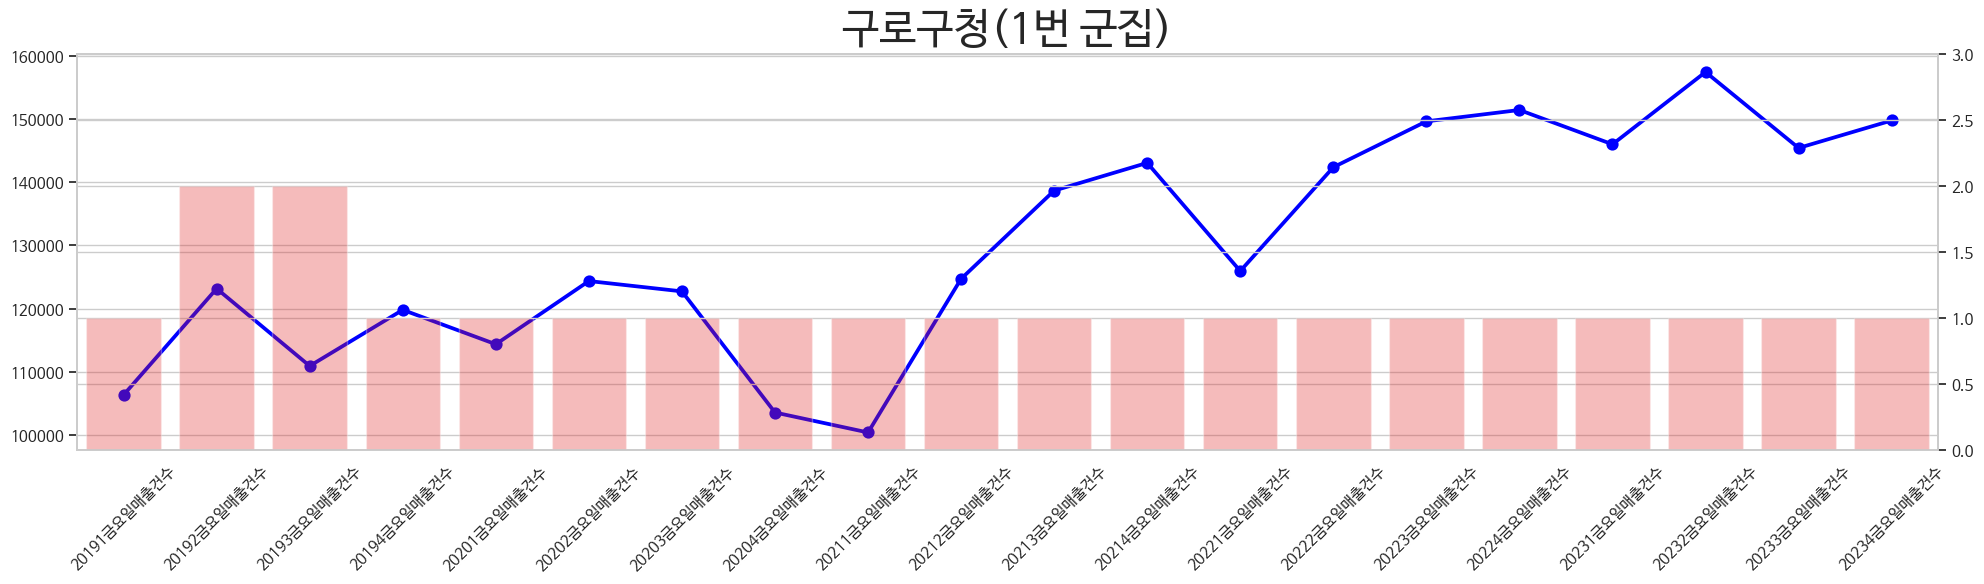

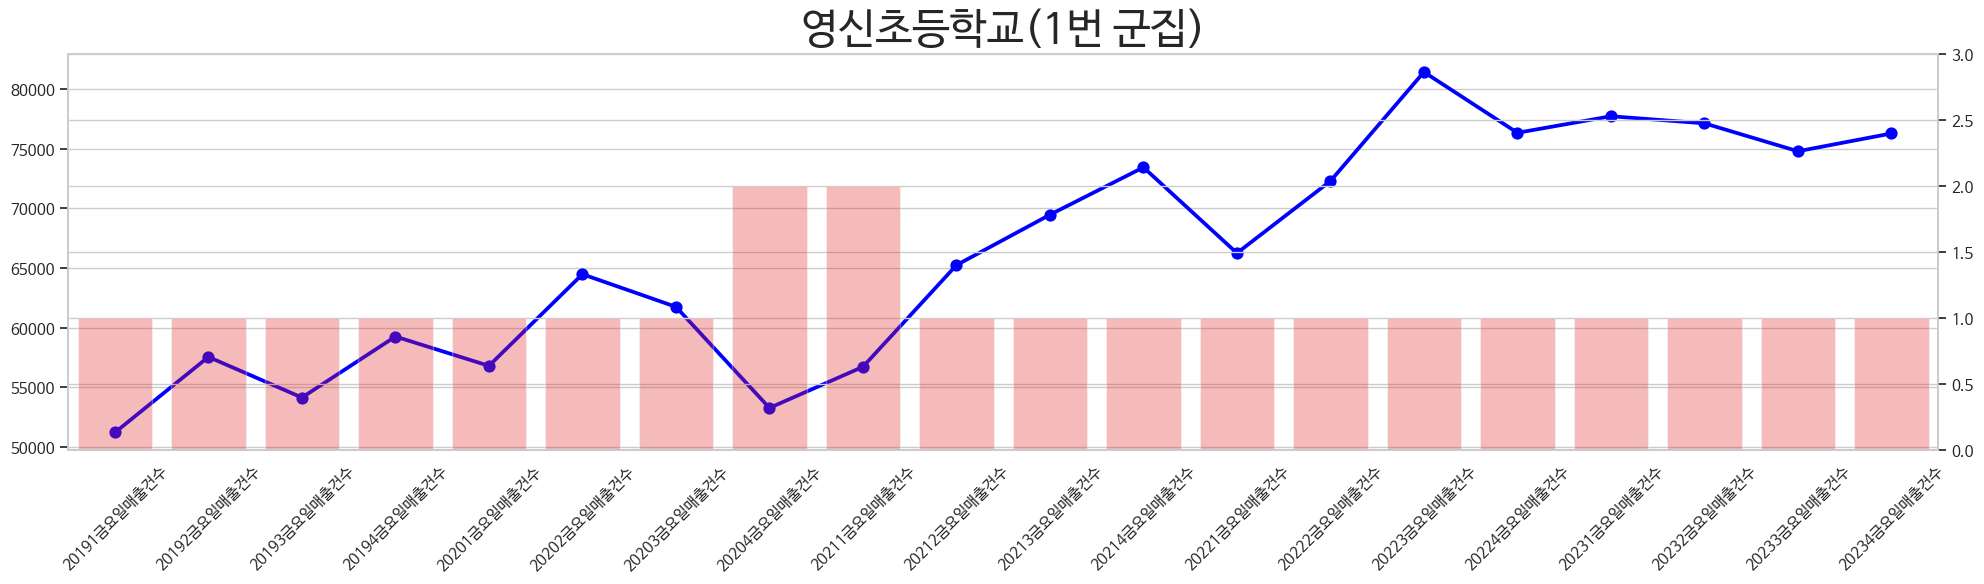

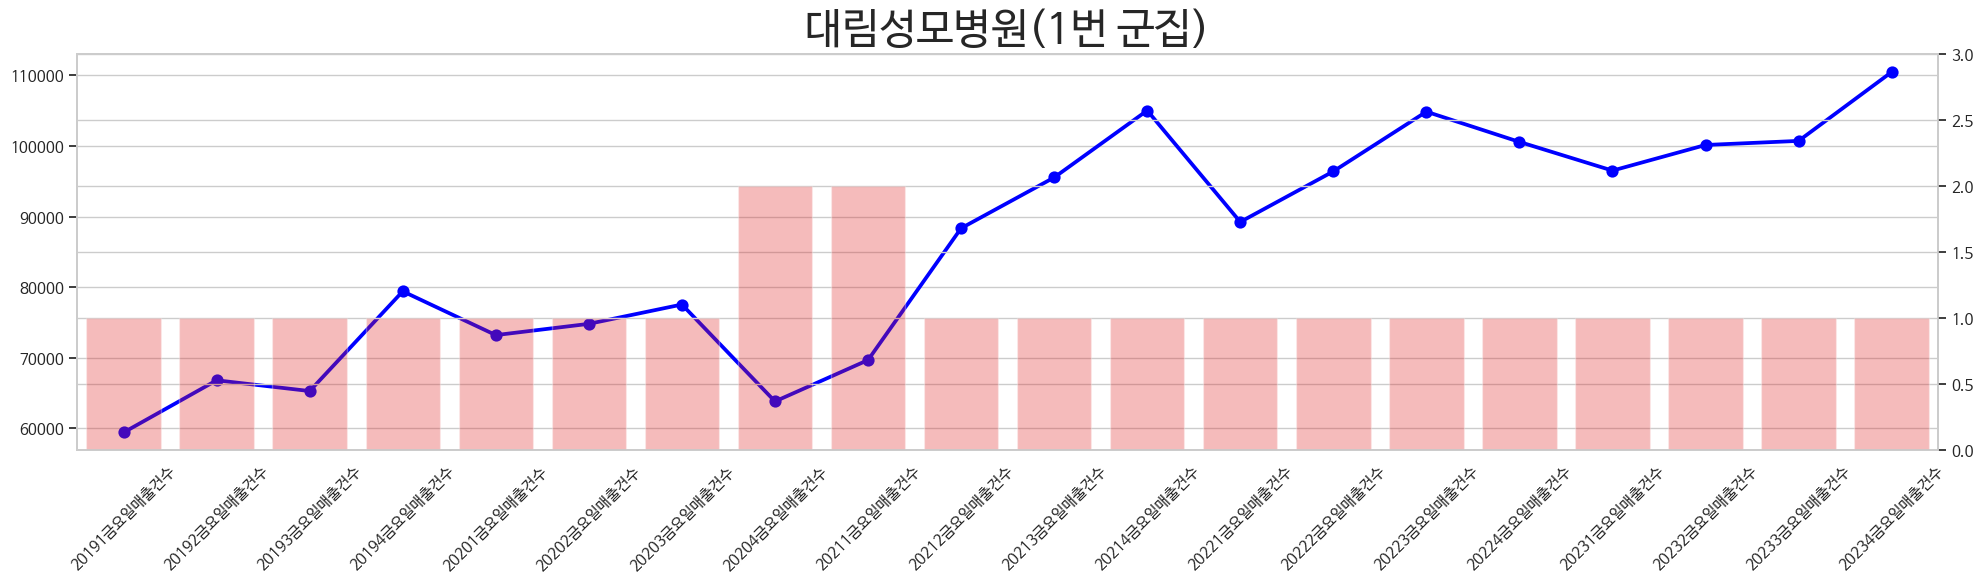

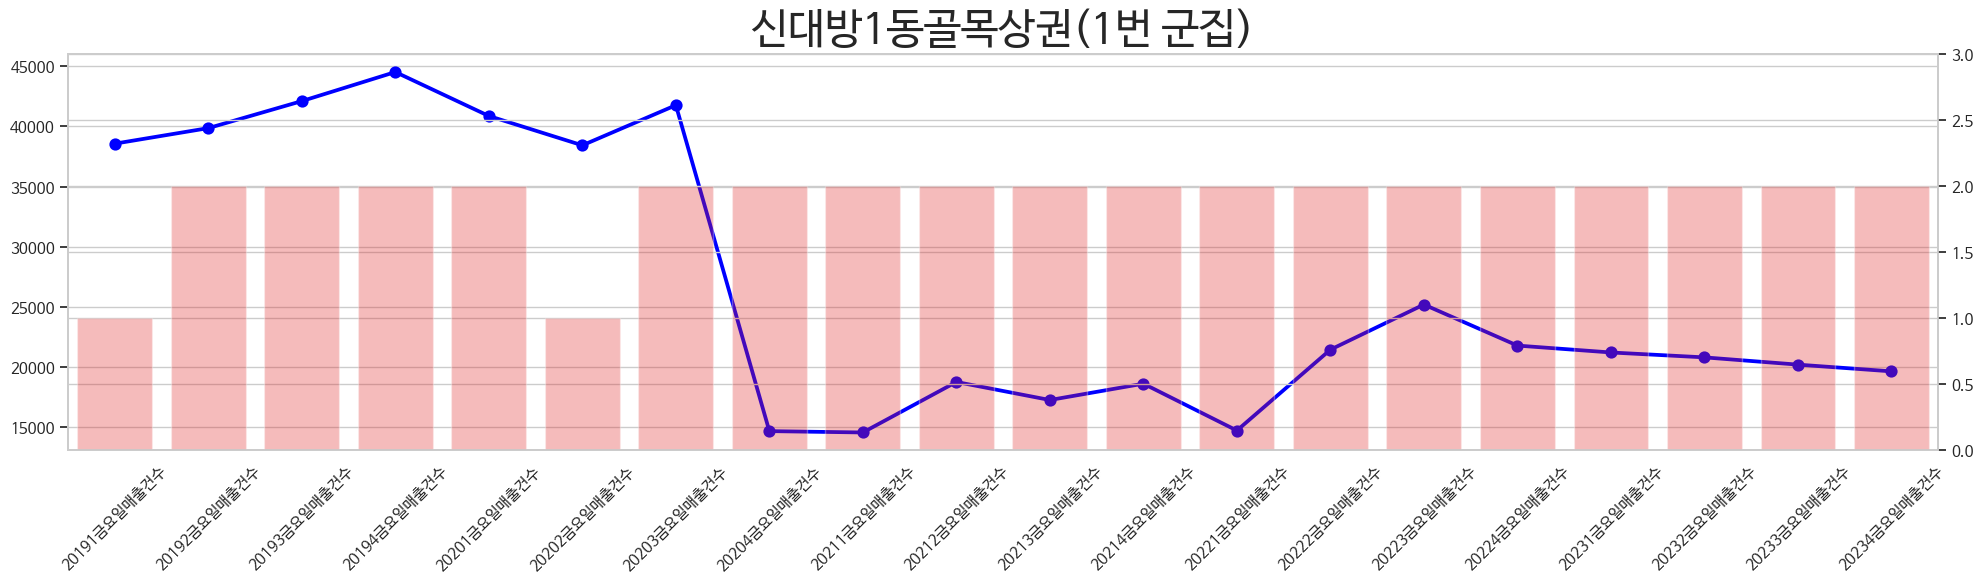

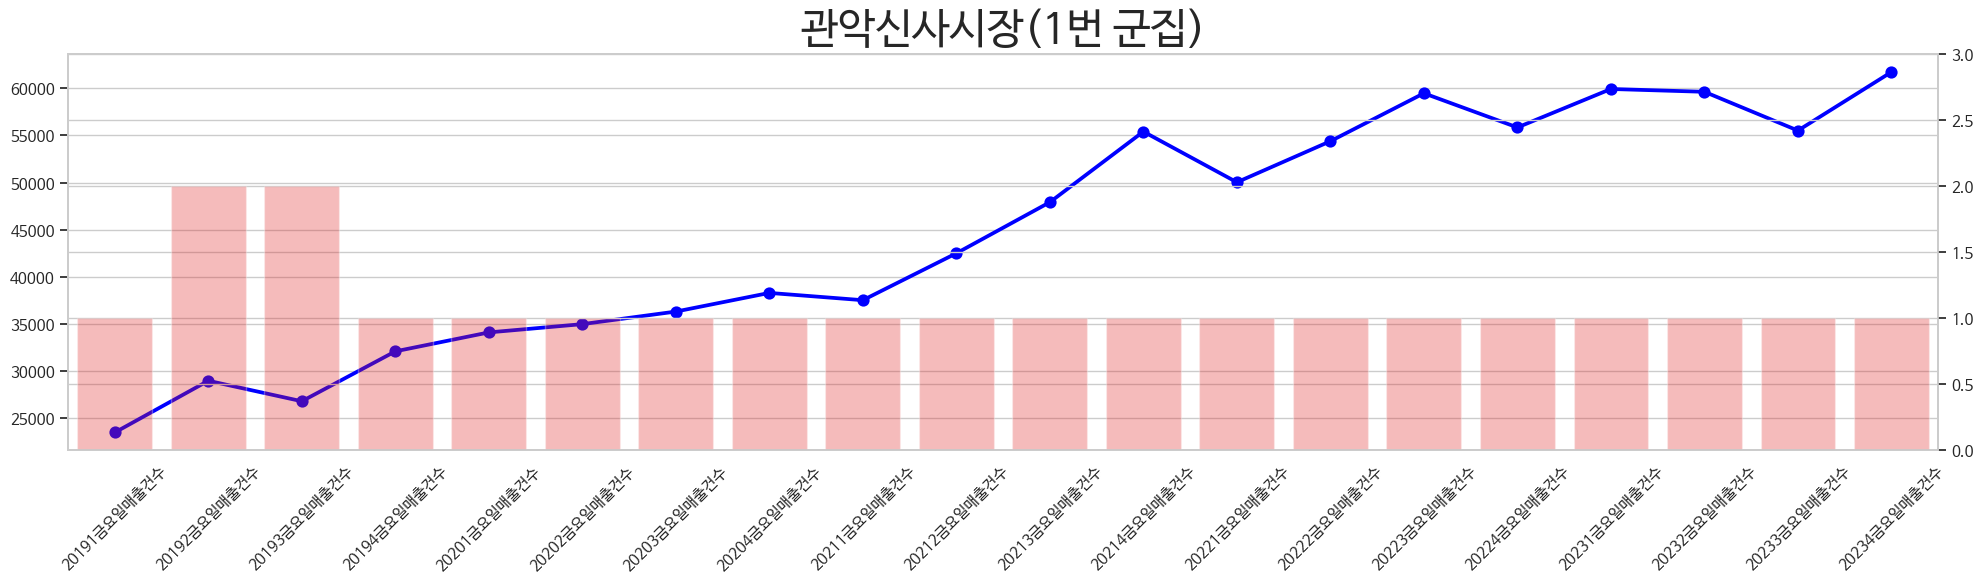

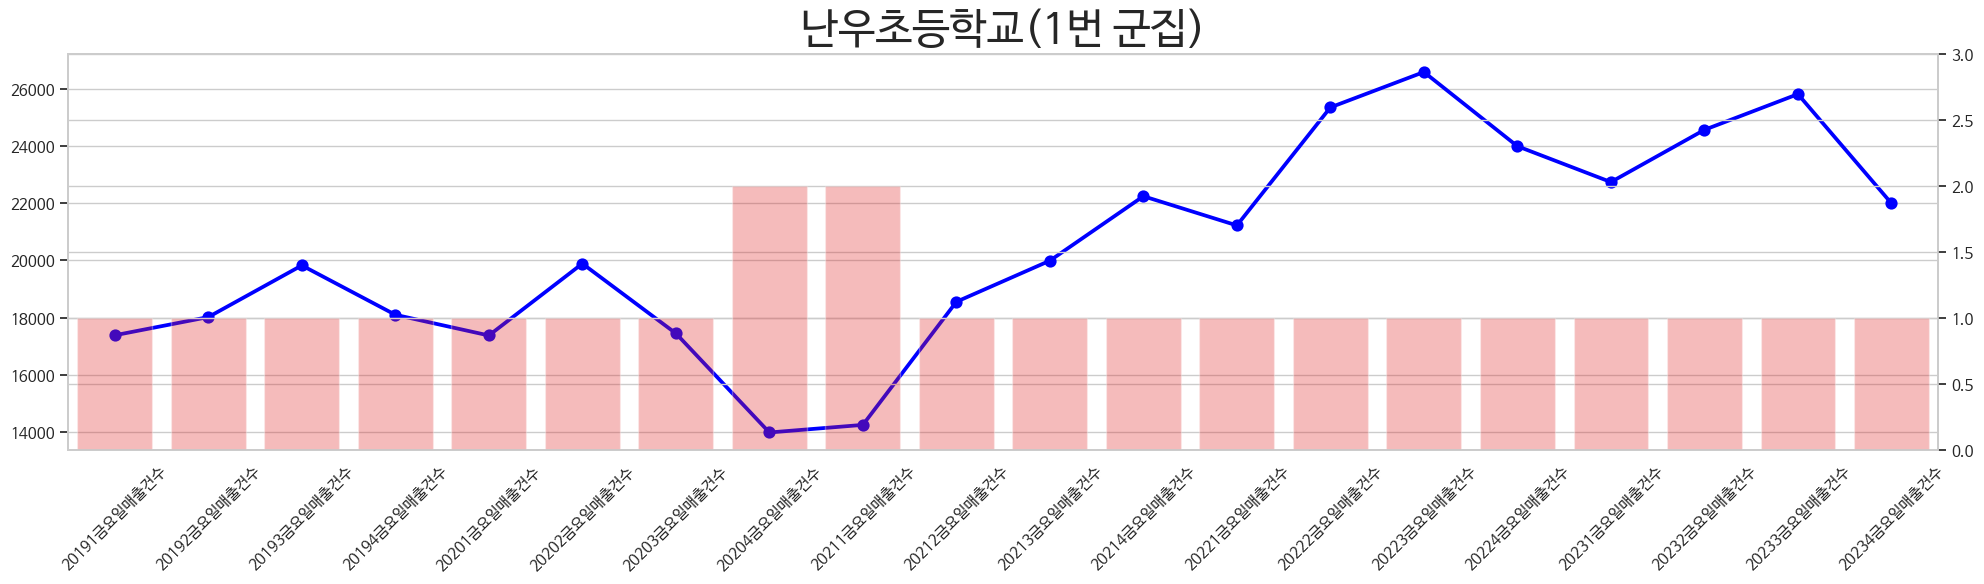

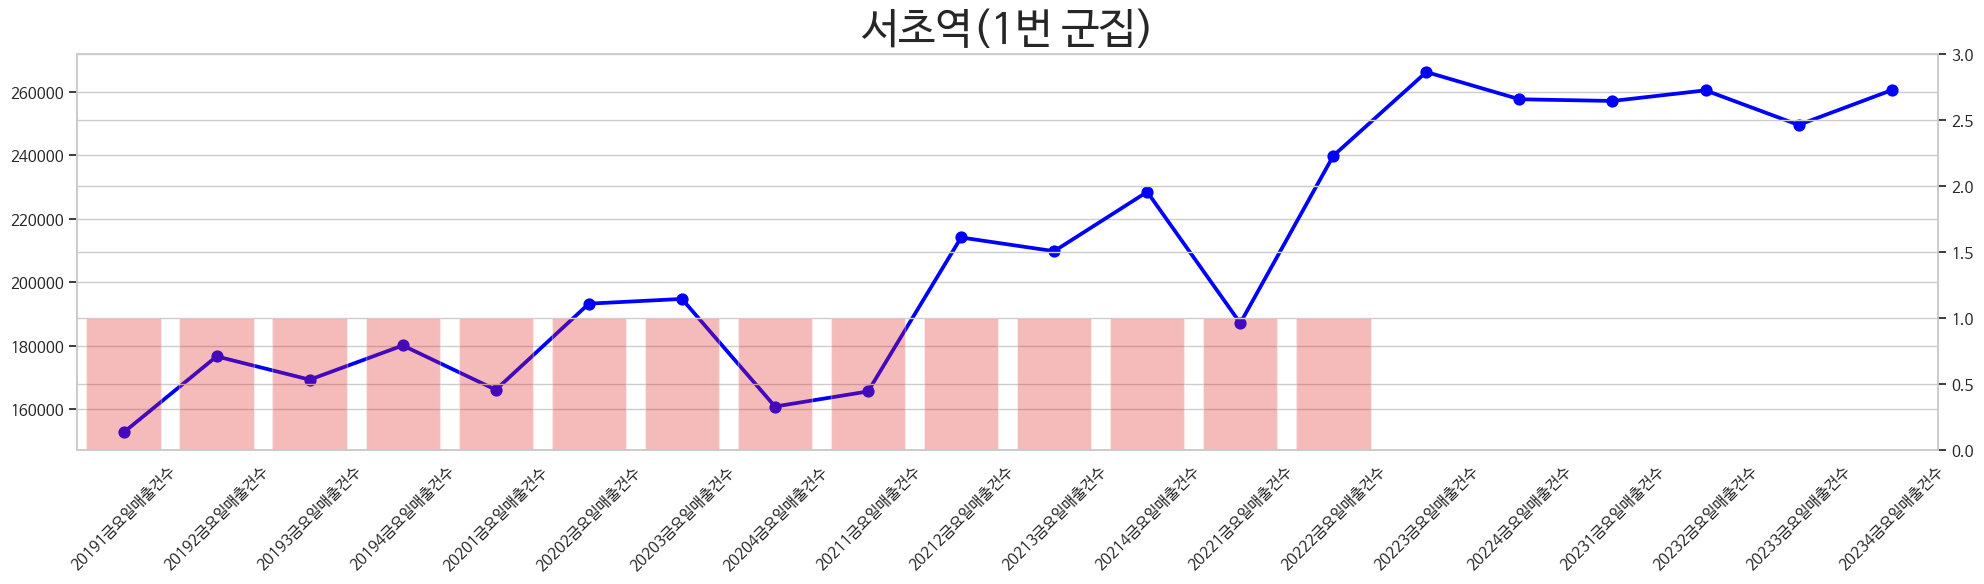

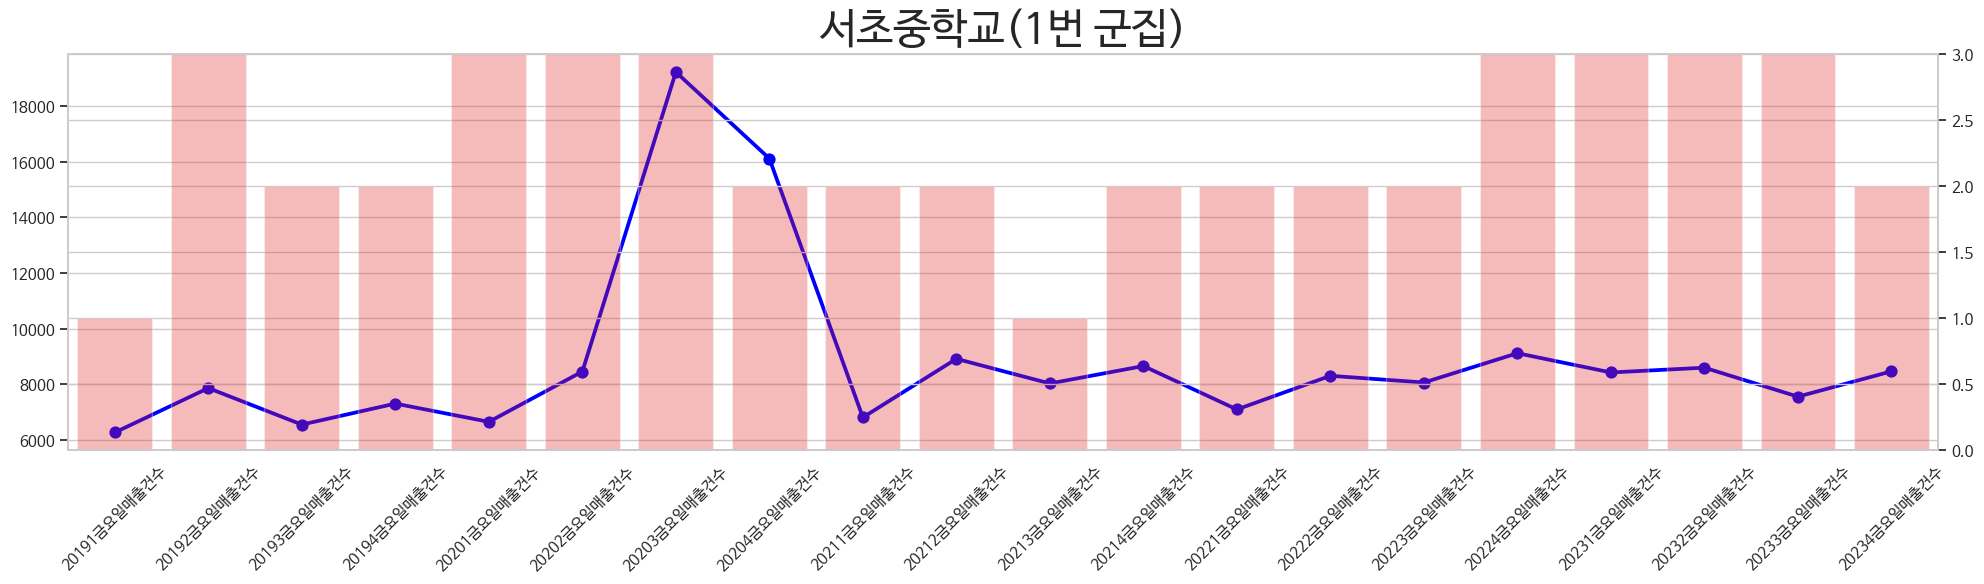

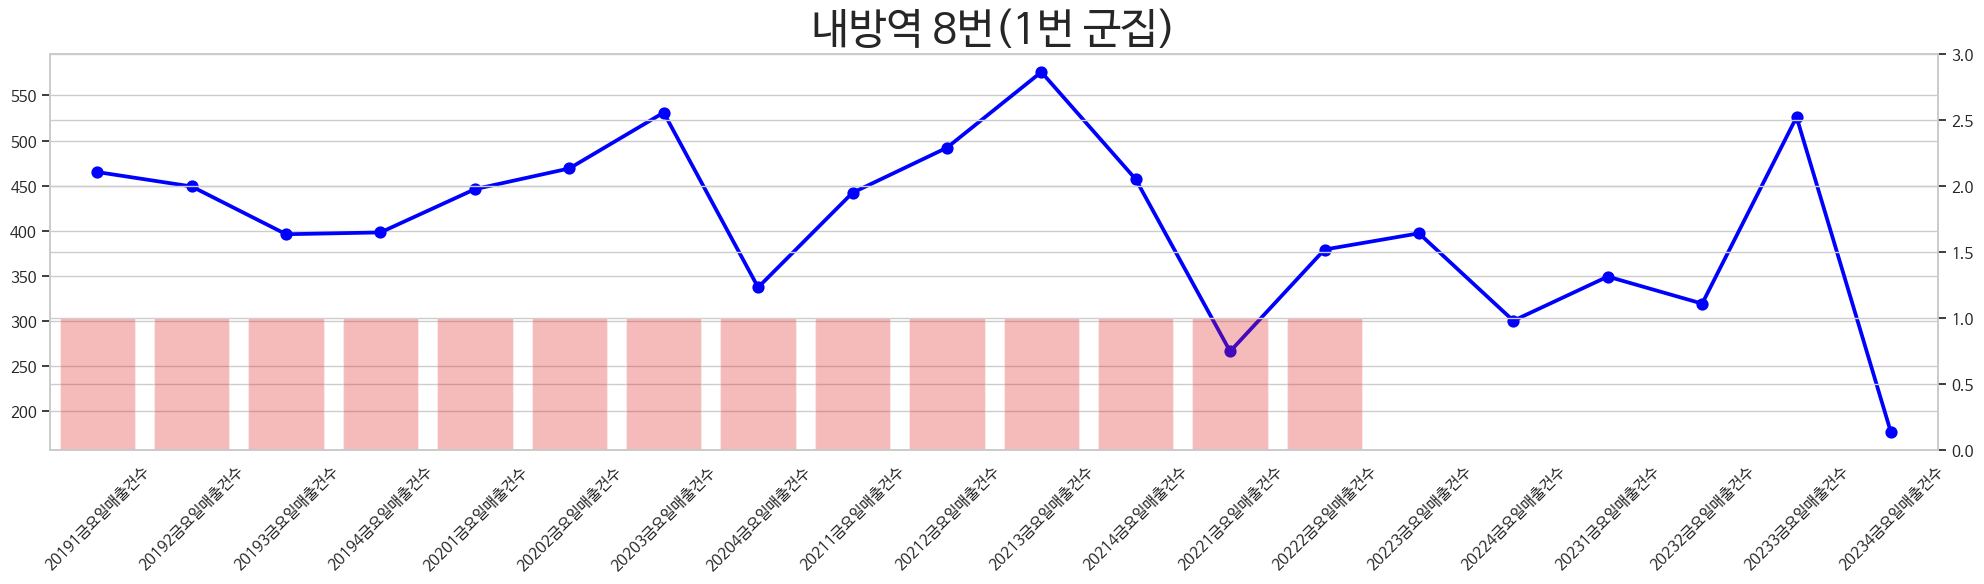

In [20]:
mask_friday_price = [col for col in data_column if '금요일매출금액' in str(col)]
mask_friday_count = [col for col in data_column if '금요일매출건수' in str(col)]

# 우리가 원하는건 매출에 대한 분석이죠?
friday_price_df = target_df[['상권'] + mask_friday_price + mask_cluster]
friday_count_df = target_df[['상권'] + mask_friday_count + mask_cluster]

friday_count_gtong, friday_count_ngtog = setting_df(friday_count_df)
for site_name in friday_count_gtong['상권'].tolist():
  diff_visualization(friday_count_gtong[friday_count_gtong['상권'] == f'{site_name}'])

In [ ]:
friday_price_gtong, friday_price_ngtog = setting_df(friday_price_df)
for site_name in friday_price_gtong['상권'].tolist():
  diff_visualization(friday_price_gtong[friday_price_gtong['상권'] == f'{site_name}'])

In [22]:
friday_price_gtong.describe().astype(int).iloc[:, :20]

,20191금요일매출금액,20192금요일매출금액,20193금요일매출금액,20194금요일매출금액,20201금요일매출금액,20202금요일매출금액,20203금요일매출금액,20204금요일매출금액,20211금요일매출금액,20212금요일매출금액,20213금요일매출금액,20214금요일매출금액,20221금요일매출금액,20222금요일매출금액,20223금요일매출금액,20224금요일매출금액,20231금요일매출금액,20232금요일매출금액,20233금요일매출금액,20234금요일매출금액
count,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
mean,951027084,951850825,937230316,1105724949,925987982,1003017539,1010877366,876599384,878154502,1290217736,1124743419,1282877176,1201980477,1264027925,1600840116,1353322613,1605112966,1640498822,1414201888,1613101796
std,1084787112,1066744728,1050690660,1284408690,974029213,1119760271,1052833889,891940788,938166322,1910585211,1290867567,1494176236,1427648926,1525043445,2308406469,1678448771,2164842504,2125423412,1663500810,2022642237
min,28942686,28908328,28944561,42868318,32813347,25653834,6908889,41361436,3257630,10451562,6786729,7736870,0,17102557,21622518,50553810,53140442,50831085,70473390,48465792
25%,218116453,251619815,274918865,355766397,271881412,255281638,290162201,278186576,268494579,273152559,279949846,282685391,222056644,283999731,331126103,367361020,290224374,438870549,298778626,505527426
50%,441341145,465109470,499391307,541475524,496182477,589759547,703469647,476602157,489419050,617645739,545908067,657374793,493401066,674117389,644166018,548913521,687736510,648207820,680427160,646366968
75%,1356347584,1423254496,1259650116,1475466676,1490822691,1495306715,1498865734,1194027011,1481986044,1561241810,1828573060,1909731190,2038801259,1831229905,2262565300,2046078034,2143680730,2109221069,2004922249,2188733372
max,3614333669,3315424524,3506935186,4330272768,3371788102,3749736522,3472424293,2971463378,3144590573,7572977473,4286504397,4834580971,4498345574,5071618399,8893204154,6154603252,7875071648,7105997886,5174629003,7106439638


In [ ]:
mask_weekend_price = [col for col in data_column if '주말매출금액' in str(col)]
mask_weekend_count = [col for col in data_column if '주말매출건수' in str(col)]

# 우리가 원하는건 매출에 대한 분석이죠?
weekend_price_df = target_df[['상권'] + mask_weekend_price + mask_cluster]
weekend_count_df = target_df[['상권'] + mask_weekend_count + mask_cluster]

weekend_price_gtong, weekend_price_ngtog = setting_df(weekend_price_df)
for site_name in weekend_price_gtong['상권'].tolist():
  diff_visualization(weekend_price_gtong[weekend_price_gtong['상권'] == f'{site_name}'])

In [ ]:
weekend_price_gtong, weekend_price_ngtog = setting_df(weekend_price_df)
for site_name in weekend_price_ngtog['상권'].tolist():
  diff_visualization(weekend_price_ngtog[weekend_price_ngtog['상권'] == f'{site_name}'])

#### 주말 결론
- 대박 찾았다
- 주말 매출 늘면 왠만하면 젠트로 가는 비중이 큼

# 방향틀꺼임
- 군집별 중위값의 변화를 확인
- 볼꺼는 당월, 주말, 남성, 여성, 10~60대

In [29]:
[col for col in data_column if '당월' in str(col)]

['20191당월매출금액',
 '20192당월매출금액',
 '20193당월매출금액',
 '20194당월매출금액',
 '20201당월매출금액',
 '20202당월매출금액',
 '20203당월매출금액',
 '20204당월매출금액',
 '20211당월매출금액',
 '20212당월매출금액',
 '20213당월매출금액',
 '20214당월매출금액',
 '20221당월매출금액',
 '20222당월매출금액',
 '20223당월매출금액',
 '20224당월매출금액',
 '20231당월매출금액',
 '20232당월매출금액',
 '20233당월매출금액',
 '20234당월매출금액',
 '20191당월매출건수',
 '20192당월매출건수',
 '20193당월매출건수',
 '20194당월매출건수',
 '20201당월매출건수',
 '20202당월매출건수',
 '20203당월매출건수',
 '20204당월매출건수',
 '20211당월매출건수',
 '20212당월매출건수',
 '20213당월매출건수',
 '20214당월매출건수',
 '20221당월매출건수',
 '20222당월매출건수',
 '20223당월매출건수',
 '20224당월매출건수',
 '20231당월매출건수',
 '20232당월매출건수',
 '20233당월매출건수',
 '20234당월매출건수']

In [35]:
mask_month_price = [col for col in data_column if '당월매출금액' in str(col)]
mask_month_count = [col for col in data_column if '주말매출건수' in str(col)]

# 우리가 원하는건 매출에 대한 분석이죠?
month_price_df = target_df[['상권'] + mask_month_price + mask_cluster]
month_count_df = target_df[['상권'] + mask_month_count + mask_cluster]

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
df = month_count_df.copy()

# 2. 클러스터별 중위값 계산을 위한 데이터프레임 생성
# 연도 및 분기별 컬럼 정리
years = ['2019', '2020', '2021', '2022', '2023']
quarters = ['1', '2', '3', '4']

# 결과를 저장할 데이터프레임 초기화
result_df = pd.DataFrame()

# 각 연도-분기에 대해 클러스터별 중위값 계산
for year in years:
  for quarter in quarters:
    period_key = f"{year}{quarter}"

    # 해당 기간의 매출 및 클러스터 컬럼
    sales_col = f"{period_key}주말매출건수"
    cluster_col = f"{period_key}_cluster"

    # 두 컬럼이 모두 존재하는지 확인
    if sales_col in df.columns and cluster_col in df.columns:
      # 기간별 클러스터 그룹화 및 중위값 계산
      period_data = df[[sales_col, cluster_col]].copy()
      period_data = period_data.dropna()  # 결측치 제거

      # 클러스터별 중위값 계산
      cluster_medians = period_data.groupby(cluster_col)[sales_col].median().reset_index()

      # 컬럼명 변경
      cluster_medians.columns = ['cluster', 'median_sales']

      # 기간 정보 추가
      cluster_medians['year'] = year
      cluster_medians['quarter'] = quarter
      cluster_medians['period'] = period_key

      # 결과 데이터프레임에 추가
      result_df = pd.concat([result_df, cluster_medians], ignore_index=True)

# 3. 시각화를 위한 데이터 재구성
# 피벗 테이블 생성: 행=기간, 열=클러스터, 값=중위값
pivot_df = result_df.pivot_table(
    index=['year', 'quarter', 'period'],
    columns='cluster',
    values='median_sales'
)

# 인덱스 리셋
pivot_df = pivot_df.reset_index()

# 시각화 함수 - 연도별 클러스터 중위값 트렌드
def plot_cluster_trends_by_year():
  plt.figure(figsize=(15, 10))

  # 각 클러스터에 대해
  for cluster in sorted(result_df['cluster'].unique()):
    # 해당 클러스터 데이터 필터링
    cluster_data = result_df[result_df['cluster'] == cluster]

    # 기간에 따른 정렬
    cluster_data = cluster_data.sort_values(by=['year', 'quarter'])

    # 플롯
    plt.plot(
        range(len(cluster_data)),
        cluster_data['median_sales'],
        marker='o',
        label=f'Cluster {cluster}'
    )

  # x축 레이블 설정
  all_periods = result_df.sort_values(by=['year', 'quarter'])['period'].unique()
  plt.xticks(range(len(all_periods)), all_periods, rotation=90)

  plt.title('클러스터별 매출 중위값 트렌드', fontsize=16)
  plt.xlabel('연도-분기', fontsize=12)
  plt.ylabel('매출 중위값', fontsize=12)
  plt.legend(title='클러스터')
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.tight_layout()

  return plt

# 히트맵 시각화 - 연도별 분기별 클러스터 매출 중위값
def plot_heatmap():
  # 피벗 테이블 다시 생성 (히트맵용)
  heatmap_df = result_df.pivot_table(
      index='period',
      columns='cluster',
      values='median_sales'
  )

  plt.figure(figsize=(12, 8))
  sns.heatmap(
      heatmap_df,
      annot=True,
      fmt='.1f',
      cmap='viridis',
      linewidths=.5
  )

  plt.title('연도-분기별 클러스터 매출 중위값 히트맵', fontsize=16)
  plt.ylabel('연도-분기')
  plt.xlabel('클러스터')
  plt.tight_layout()

  return plt

# 4. 클러스터별 상권 수 분석
def analyze_cluster_distribution():
  # 각 기간별 클러스터 분포 계산
  cluster_counts = pd.DataFrame()

  for year in years:
    for quarter in quarters:
      period_key = f"{year}{quarter}"
      cluster_col = f"{period_key}_cluster"

      if cluster_col in df.columns:
        # 클러스터별 상권 수 계산
        period_counts = df[cluster_col].value_counts().reset_index()
        period_counts.columns = ['cluster', 'count']
        period_counts['period'] = period_key

        # 결과에 추가
        cluster_counts = pd.concat([cluster_counts, period_counts], ignore_index=True)

  # 시각화
  plt.figure(figsize=(15, 8))

  # 각 기간별로 클러스터 분포 막대 그래프
  sns.barplot(
      data=cluster_counts,
      x='period',
      y='count',
      hue='cluster'
  )

  plt.title('연도-분기별 클러스터 상권 수 분포', fontsize=16)
  plt.xlabel('연도-분기', fontsize=12)
  plt.ylabel('상권 수', fontsize=12)
  plt.xticks(rotation=90)
  plt.legend(title='클러스터')
  plt.tight_layout()

  return plt, cluster_counts

# 5. 결과 실행 및 시각화
trend_plot = plot_cluster_trends_by_year()
trend_plot.savefig('cluster_trends.png')

heatmap_plot = plot_heatmap()
heatmap_plot.savefig('cluster_heatmap.png')

distribution_plot, cluster_counts = analyze_cluster_distribution()
distribution_plot.savefig('cluster_distribution.png')

# 결과 데이터프레임 저장
result_df.to_csv('cluster_medians.csv', index=False)
pivot_df.to_csv('cluster_medians_pivot.csv', index=False)
cluster_counts.to_csv('cluster_counts.csv', index=False)

print("분석 완료. 결과 파일이 저장되었습니다.")

In [ ]:
def help_me_median(target_df, category_name):

  mask_1 = [col for col in data_column if f'{category_name}' in str(col)]

  # 우리가 원하는건 매출에 대한 분석이죠?
  df_mask = target_df[['상권'] + mask_1 + mask_cluster]

  # 1. 데이터 불러오기
  df = df_mask.copy()

  # 2. 클러스터별 중위값 계산을 위한 데이터프레임 생성
  # 연도 및 분기별 컬럼 정리
  years = ['2019', '2020', '2021', '2022', '2023']
  quarters = ['1', '2', '3', '4']

  # 결과를 저장할 데이터프레임 초기화
  result_df = pd.DataFrame()

  # 각 연도-분기에 대해 클러스터별 중위값 계산
  for year in years:
    for quarter in quarters:
      period_key = f"{year}{quarter}"

      # 해당 기간의 매출 및 클러스터 컬럼
      sales_col = f"{period_key}{category_name}"
      cluster_col = f"{period_key}_cluster"

      # 두 컬럼이 모두 존재하는지 확인
      if sales_col in df.columns and cluster_col in df.columns:
        # 기간별 클러스터 그룹화 및 중위값 계산
        period_data = df[[sales_col, cluster_col]].copy()
        period_data = period_data.dropna()  # 결측치 제거

        # 클러스터별 중위값 계산
        cluster_medians = period_data.groupby(cluster_col)[sales_col].median().reset_index()

        # 컬럼명 변경
        cluster_medians.columns = ['cluster', 'median_sales']

        # 기간 정보 추가
        cluster_medians['year'] = year
        cluster_medians['quarter'] = quarter
        cluster_medians['period'] = period_key

        # 결과 데이터프레임에 추가
        result_df = pd.concat([result_df, cluster_medians], ignore_index=True)

  # 3. 시각화를 위한 데이터 재구성
  # 피벗 테이블 생성: 행=기간, 열=클러스터, 값=중위값
  pivot_df = result_df.pivot_table(
      index=['year', 'quarter', 'period'],
      columns='cluster',
      values='median_sales'
  )

  # 인덱스 리셋
  pivot_df = pivot_df.reset_index()

  # 시각화 함수 - 연도별 클러스터 중위값 트렌드
  def plot_cluster_trends_by_year():
    plt.figure(figsize=(20, 4))

    # 각 클러스터에 대해
    for cluster in sorted(result_df['cluster'].unique()):
      # 해당 클러스터 데이터 필터링
      cluster_data = result_df[result_df['cluster'] == cluster]

      # 기간에 따른 정렬
      cluster_data = cluster_data.sort_values(by=['year', 'quarter'])

      # 플롯
      plt.plot(
          range(len(cluster_data)),
          cluster_data['median_sales'],
          marker='o',
          label=f'Cluster {cluster}'
      )

    # x축 레이블 설정
    all_periods = result_df.sort_values(by=['year', 'quarter'])['period'].unique()
    plt.xticks(range(len(all_periods)), all_periods, rotation=45)

    plt.title(f'{category_name}의 클러스터별 중위값 트렌드', fontsize=16)
    plt.xlabel('연도-분기', fontsize=12)
    plt.ylabel(f'{category_name} 중위값', fontsize=12)
    plt.legend(title='클러스터')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

  # 5. 결과 실행 및 시각화
  trend_plot = plot_cluster_trends_by_year()
  return plt.show()

def help_me_mean(target_df, category_name):

  mask_1 = [col for col in data_column if f'{category_name}' in str(col)]

  # 우리가 원하는건 매출에 대한 분석이죠?
  df_mask = target_df[['상권'] + mask_1 + mask_cluster]

  # 1. 데이터 불러오기
  df = df_mask.copy()

  # 2. 클러스터별 평균균값 계산을 위한 데이터프레임 생성
  # 연도 및 분기별 컬럼 정리
  years = ['2019', '2020', '2021', '2022', '2023']
  quarters = ['1', '2', '3', '4']

  # 결과를 저장할 데이터프레임 초기화
  result_df = pd.DataFrame()

  # 각 연도-분기에 대해 클러스터별 평균균값 계산
  for year in years:
    for quarter in quarters:
      period_key = f"{year}{quarter}"

      # 해당 기간의 매출 및 클러스터 컬럼
      sales_col = f"{period_key}{category_name}"
      cluster_col = f"{period_key}_cluster"

      # 두 컬럼이 모두 존재하는지 확인
      if sales_col in df.columns and cluster_col in df.columns:
        # 기간별 클러스터 그룹화 및 평균균값 계산
        period_data = df[[sales_col, cluster_col]].copy()
        period_data = period_data.dropna()  # 결측치 제거

        # 클러스터별 평균균값 계산
        cluster_medians = period_data.groupby(cluster_col)[sales_col].mean().reset_index()

        # 컬럼명 변경
        cluster_medians.columns = ['cluster', 'mean_sales']

        # 기간 정보 추가
        cluster_medians['year'] = year
        cluster_medians['quarter'] = quarter
        cluster_medians['period'] = period_key

        # 결과 데이터프레임에 추가
        result_df = pd.concat([result_df, cluster_medians], ignore_index=True)

  # 3. 시각화를 위한 데이터 재구성
  # 피벗 테이블 생성: 행=기간, 열=클러스터, 값=중위값
  pivot_df = result_df.pivot_table(
      index=['year', 'quarter', 'period'],
      columns='cluster',
      values='mean_sales'
  )

  # 인덱스 리셋
  pivot_df = pivot_df.reset_index()

  # 시각화 함수 - 연도별 클러스터 중위값 트렌드
  def plot_cluster_trends_by_year():
    plt.figure(figsize=(20, 4))

    # 각 클러스터에 대해
    for cluster in sorted(result_df['cluster'].unique()):
      # 해당 클러스터 데이터 필터링
      cluster_data = result_df[result_df['cluster'] == cluster]

      # 기간에 따른 정렬
      cluster_data = cluster_data.sort_values(by=['year', 'quarter'])

      # 플롯
      plt.plot(
          range(len(cluster_data)),
          cluster_data['mean_sales'],
          marker='o',
          label=f'Cluster {cluster}'
      )

    # x축 레이블 설정
    all_periods = result_df.sort_values(by=['year', 'quarter'])['period'].unique()
    plt.xticks(range(len(all_periods)), all_periods, rotation=45)

    plt.title(f'{category_name}의 클러스터별 평균값 트렌드', fontsize=16)
    plt.xlabel('연도-분기', fontsize=12)
    plt.ylabel(f'{category_name} 평균값', fontsize=12)
    plt.legend(title='클러스터')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt

  # 5. 결과 실행 및 시각화
  trend_plot = plot_cluster_trends_by_year()
  return plt.show()

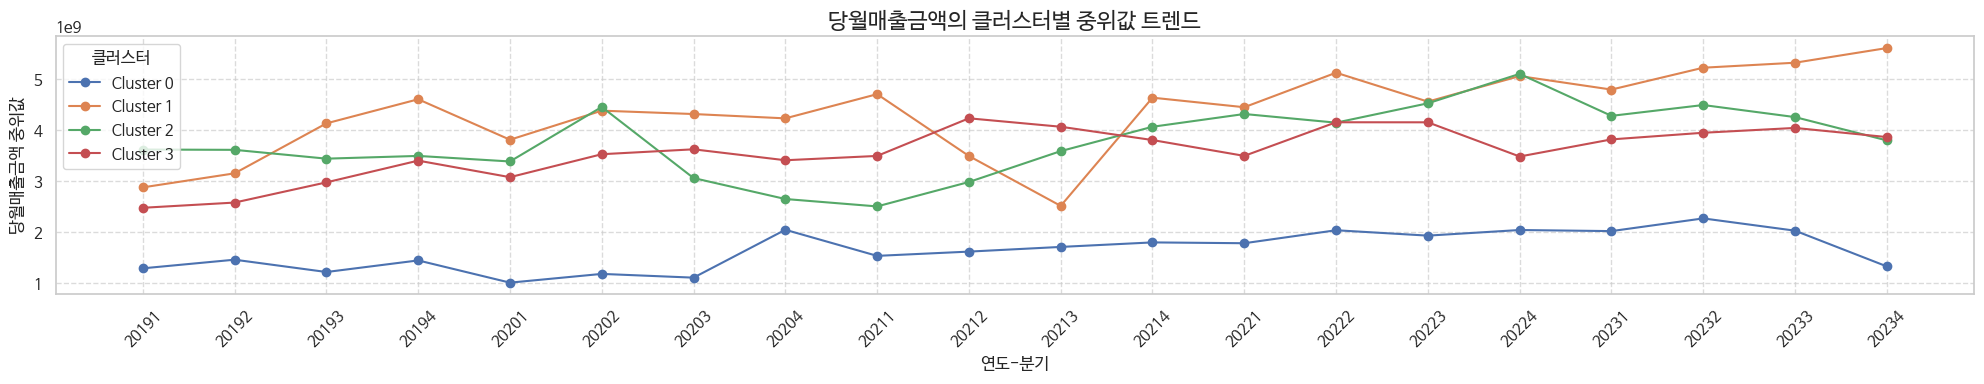

In [48]:
help_me_median(target_df, '당월매출금액')

In [45]:
target_df.columns.tolist()

['상권구분코드',
 '상권구분',
 '상권코드',
 '상권',
 'x좌표',
 'y좌표',
 '자치구코드',
 '자치구',
 '행정동코드',
 '행정동',
 '영역면적',
 '20191점포수',
 '20192점포수',
 '20193점포수',
 '20194점포수',
 '20201점포수',
 '20202점포수',
 '20203점포수',
 '20204점포수',
 '20211점포수',
 '20212점포수',
 '20213점포수',
 '20214점포수',
 '20221점포수',
 '20222점포수',
 '20223점포수',
 '20224점포수',
 '20231점포수',
 '20232점포수',
 '20233점포수',
 '20234점포수',
 '20191유사업종점포수',
 '20192유사업종점포수',
 '20193유사업종점포수',
 '20194유사업종점포수',
 '20201유사업종점포수',
 '20202유사업종점포수',
 '20203유사업종점포수',
 '20204유사업종점포수',
 '20211유사업종점포수',
 '20212유사업종점포수',
 '20213유사업종점포수',
 '20214유사업종점포수',
 '20221유사업종점포수',
 '20222유사업종점포수',
 '20223유사업종점포수',
 '20224유사업종점포수',
 '20231유사업종점포수',
 '20232유사업종점포수',
 '20233유사업종점포수',
 '20234유사업종점포수',
 '20191개업점포수',
 '20192개업점포수',
 '20193개업점포수',
 '20194개업점포수',
 '20201개업점포수',
 '20202개업점포수',
 '20203개업점포수',
 '20204개업점포수',
 '20211개업점포수',
 '20212개업점포수',
 '20213개업점포수',
 '20214개업점포수',
 '20221개업점포수',
 '20222개업점포수',
 '20223개업점포수',
 '20224개업점포수',
 '20231개업점포수',
 '20232개업점포수',
 '20233개업점포수',
 '20234개업점포수',
 '2

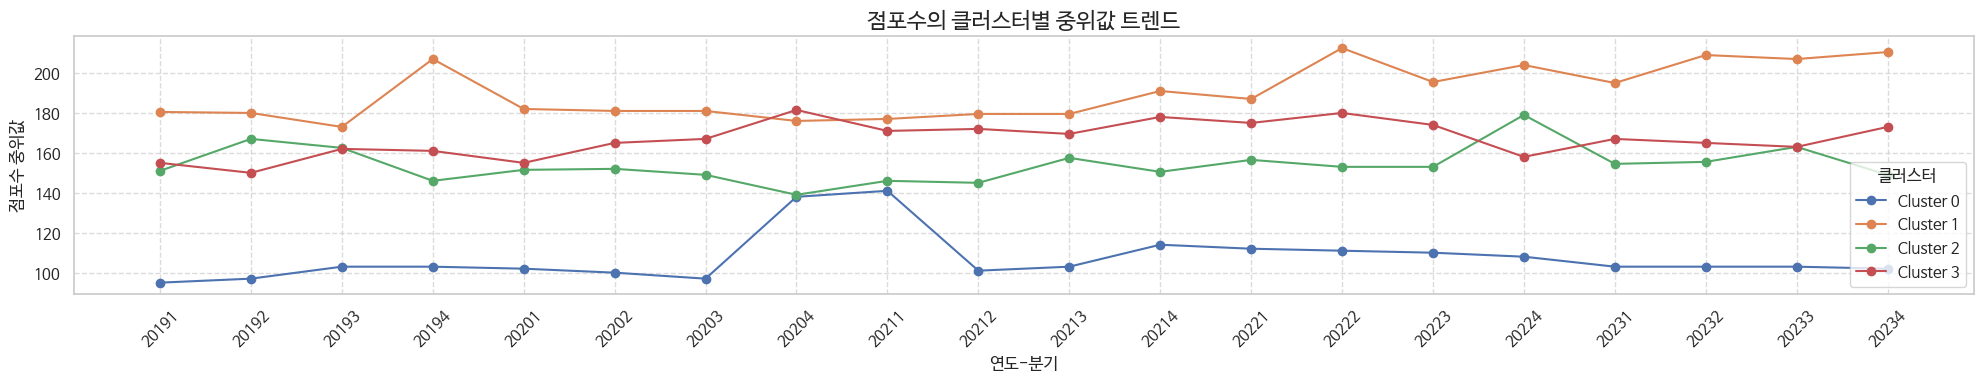

In [52]:
help_me_median(target_df, '점포수')

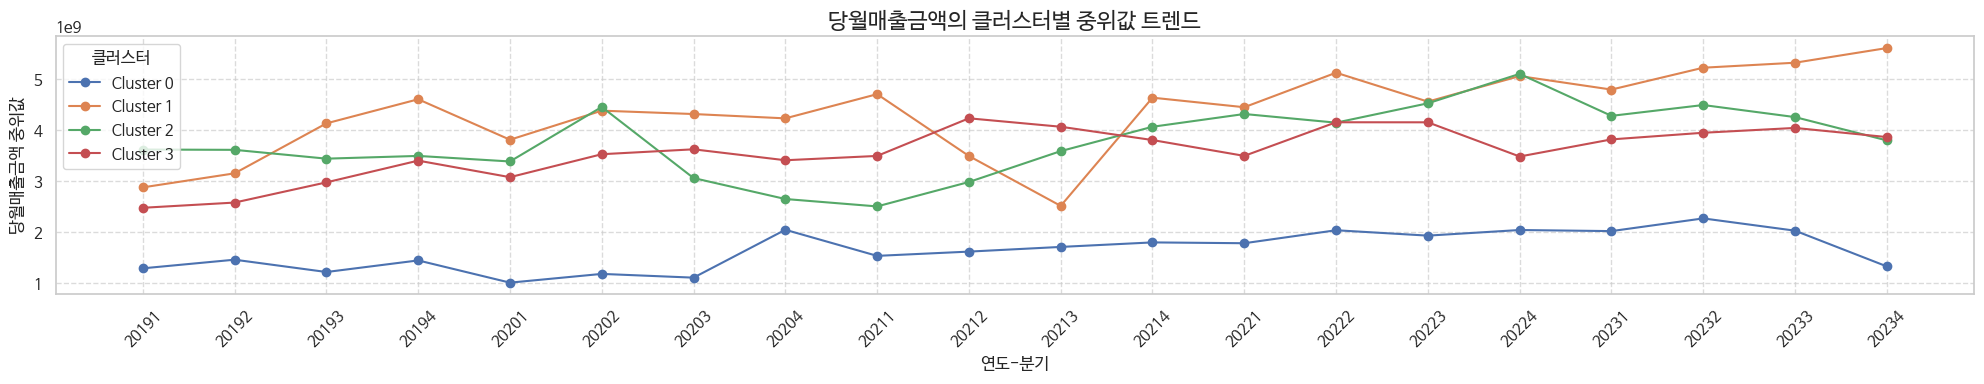

None

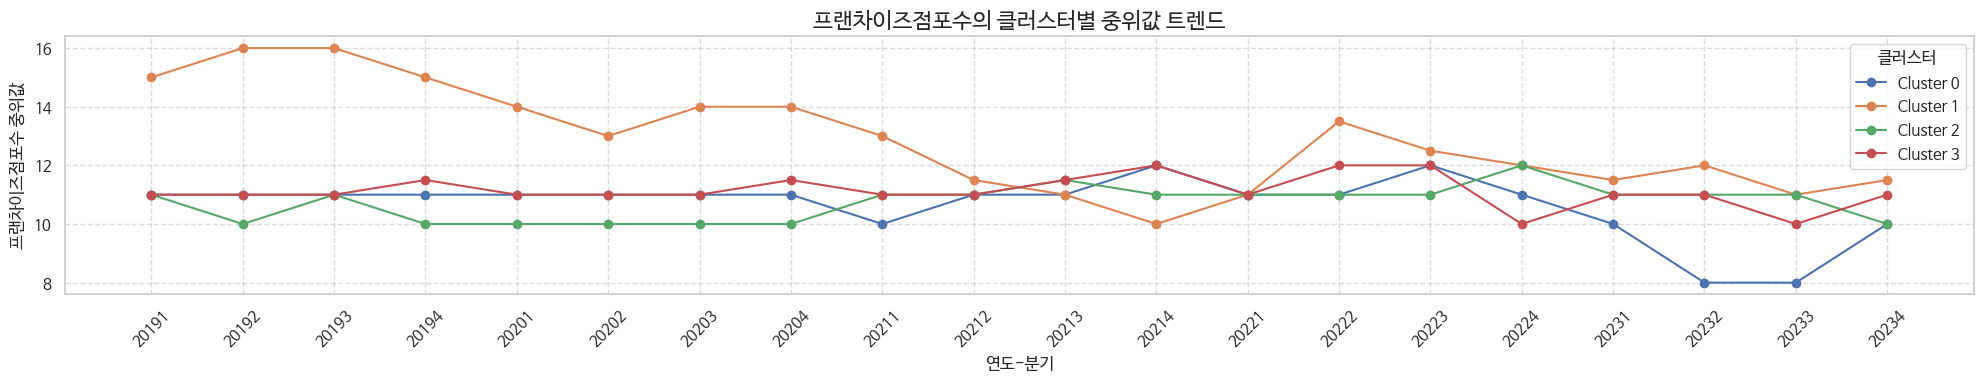

None

In [ ]:
display(help_me_median(target_df, '당월매출금액'))
display(help_me_median(target_df, '프랜차이즈점포수'))

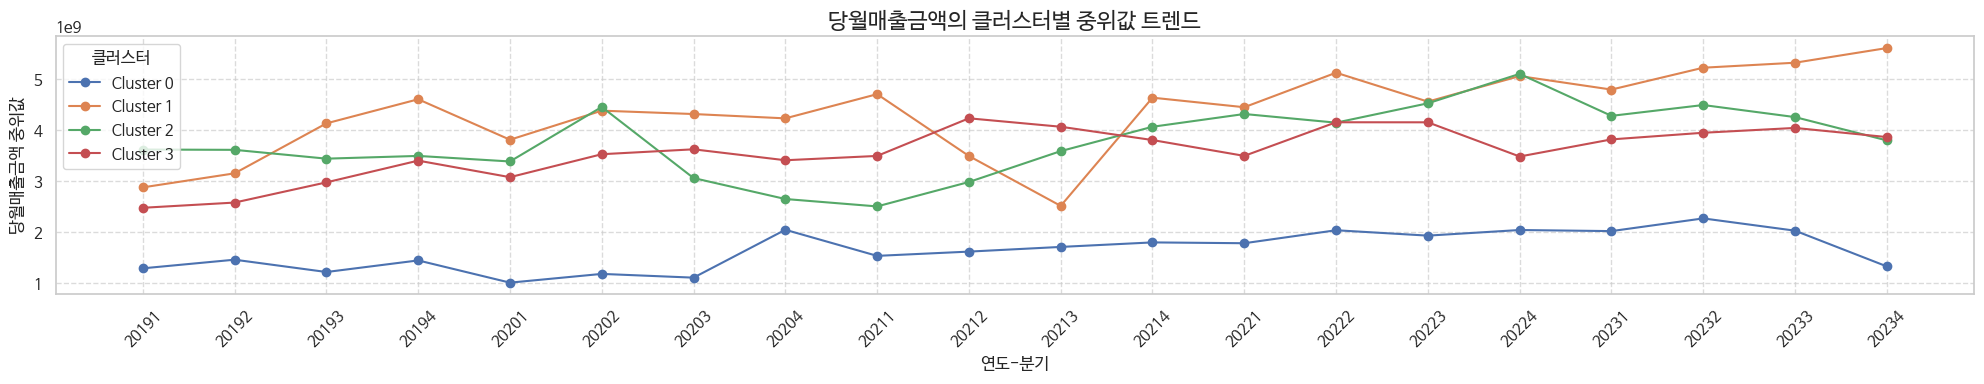

None

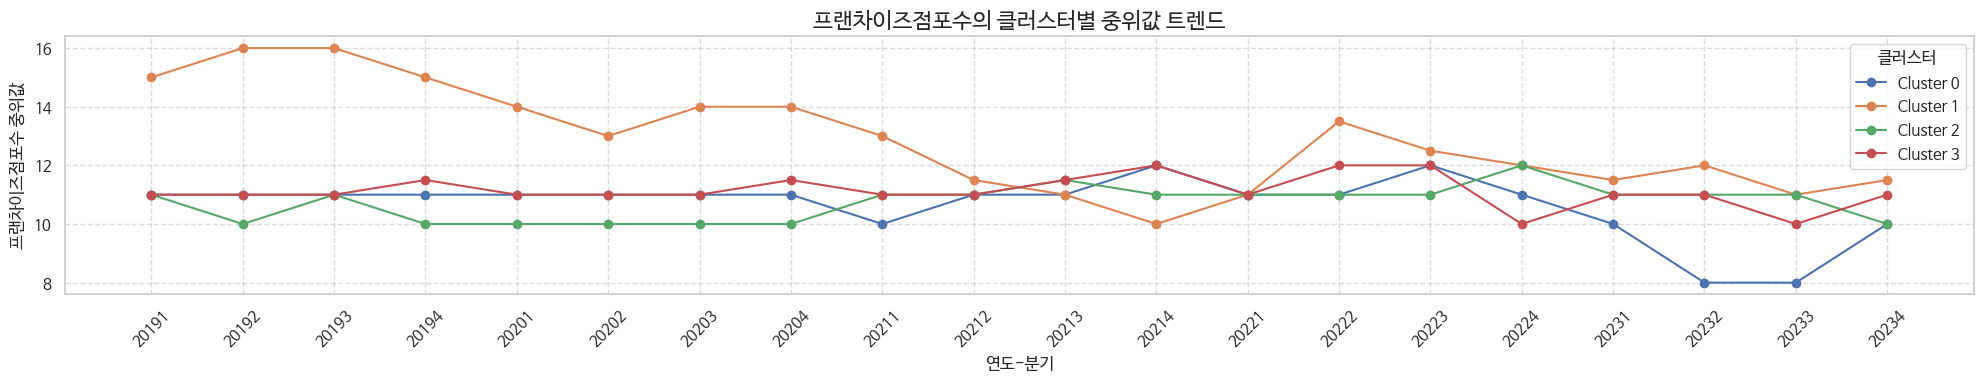

None

In [56]:
display(help_me_median(target_df, '당월매출금액'))
display(help_me_median(target_df, '프랜차이즈점포수'))

In [ ]:
store_lst = ['점포수', '유사업종점포수', '개업점포수', '폐업점포수', '프랜차이즈점포수']
pop_floating_lst = ['총유동인구수', '남성유동인구수', '여성유동인구수',
                    '연령대10유동인구수', '연령대20유동인구수', '연령대30유동인구수', '연령대40유동인구수', '연령대50유동인구수', '연령대60이상유동인구수'
                    '시간대0006유동인구수', '시간대0611유동인구수', '시간대1114유동인구수', '시간대1721유동인구수', '시간대2124유동인구수',
                    '월요일유동인구수', '화요일유동인구수', '수요일유동인구수', '목요일유동인구수', '금요일유동인구수', '토요일유동인구수', '일요일유동인구수',
                    ]
pop_stay_lst = ['총상주인구수', '남성상주인구수', '여성상주인구수',
                '연령대10상주인구수', '연령대20상주인구수', '연령대30상주인구수', '연령대40상주인구수', '연령대50상주인구수', '연령대60이상상주인구수'
                '시간대0006상주인구수', '시간대0611상주인구수', '시간대1114상주인구수', '시간대1721상주인구수', '시간대2124상주인구수',
                '월요일상주인구수', '화요일상주인구수', '수요일상주인구수', '목요일상주인구수', '금요일상주인구수', '토요일상주인구수', '일요일상주인구수',
                ]
pop_work_lst = ['총직장인구수', '남성직장인구수', '여성직장인구수',
                '연령대10직장인구수', '연령대20직장인구수', '연령대30직장인구수', '연령대40직장인구수', '연령대50직장인구수', '연령대60이상직장인구수'
                ]
sales_price_lst = ['당월매출금액', '주말매출금액',
                   '월요일매출금액', '화요일매출금액', '수요일매출금액', '목요일매출금액', '금요일매출금액', '토요일매출금액', '일요일매출금액',
                   '시간대0006매출금액', '시간대0611매출금액', '시간대1114매출금액', '시간대1721매출금액', '시간대2124매출금액',
                   '남성매출금액', '여성매출금액',
                   '연령대10매출금액', '연령대20매출금액', '연령대30매출금액', '연령대40매출금액', '연령대50매출금액', '연령대60이상매출금액'
                   ]
sales_count_lst = ['당월매출건수', '주말매출건수',
                   '월요일매출건수', '화요일매출건수', '수요일매출건수', '목요일매출건수', '금요일매출건수', '토요일매출건수', '일요일매출건수',
                   '시간대0006매출건수', '시간대0611매출건수', '시간대1114매출건수', '시간대1721매출건수', '시간대2124매출건수',
                   '남성매출건수', '여성매출건수',
                   '연령대10매출건수', '연령대20매출건수', '연령대30매출건수', '연령대40매출건수', '연령대50매출건수', '연령대60이상매출건수'
                   ]
store_stay_lst = ['운영영업개월평균', '폐업영업개월평균']
store_price_lst = ['총계임대료', '1층임대료', '1층외임대료']

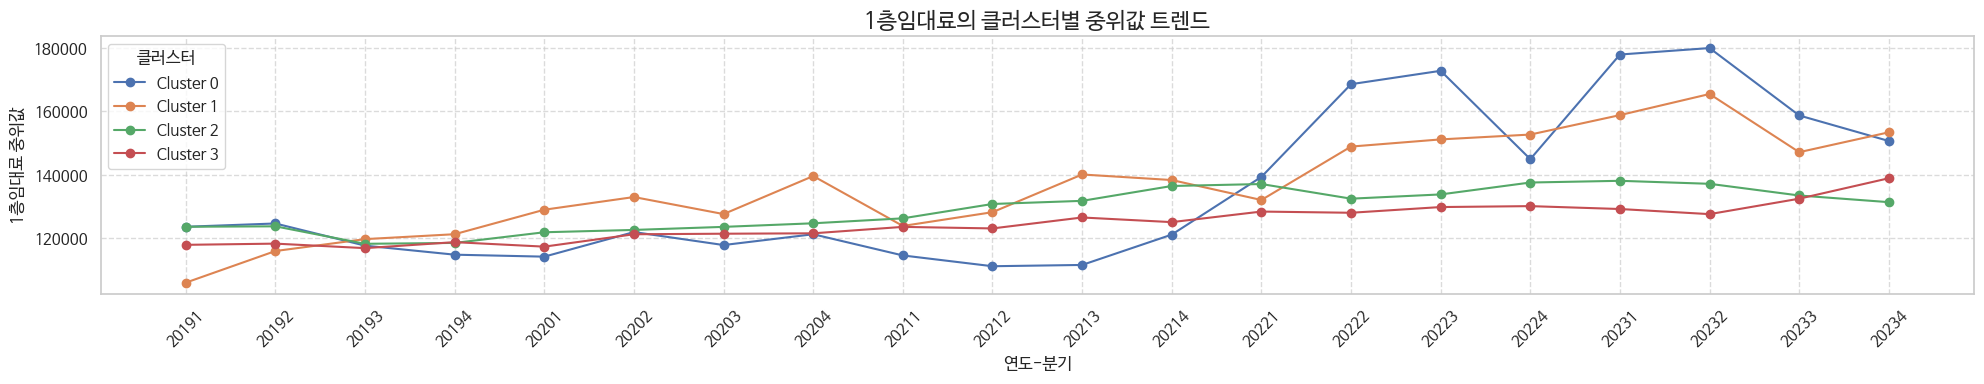

None

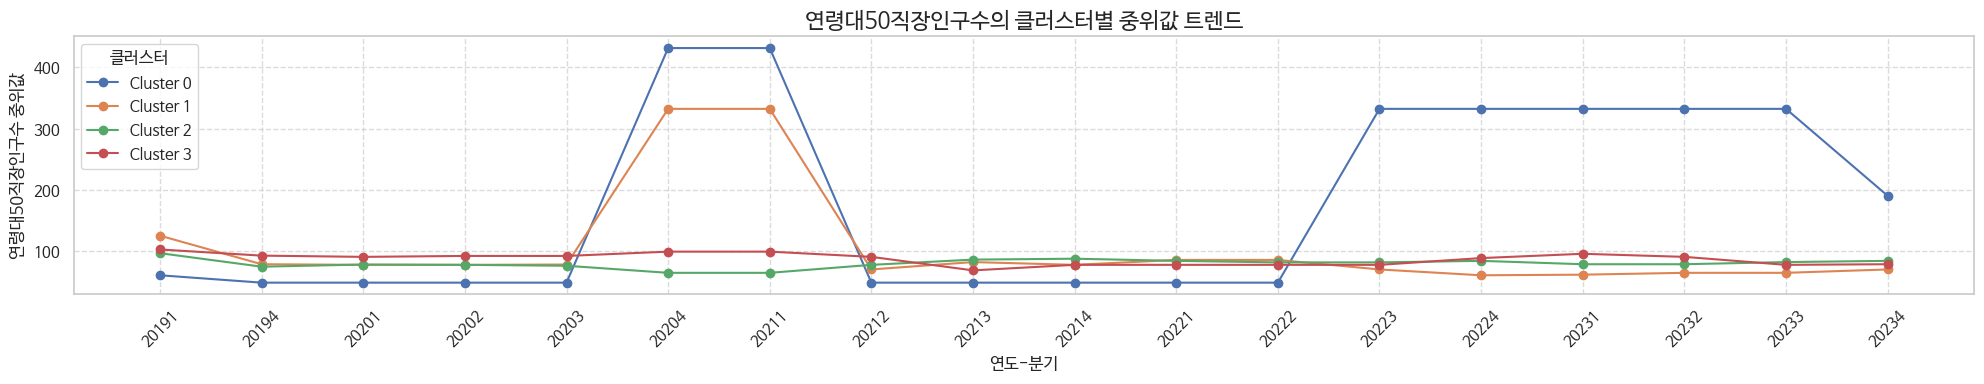

None

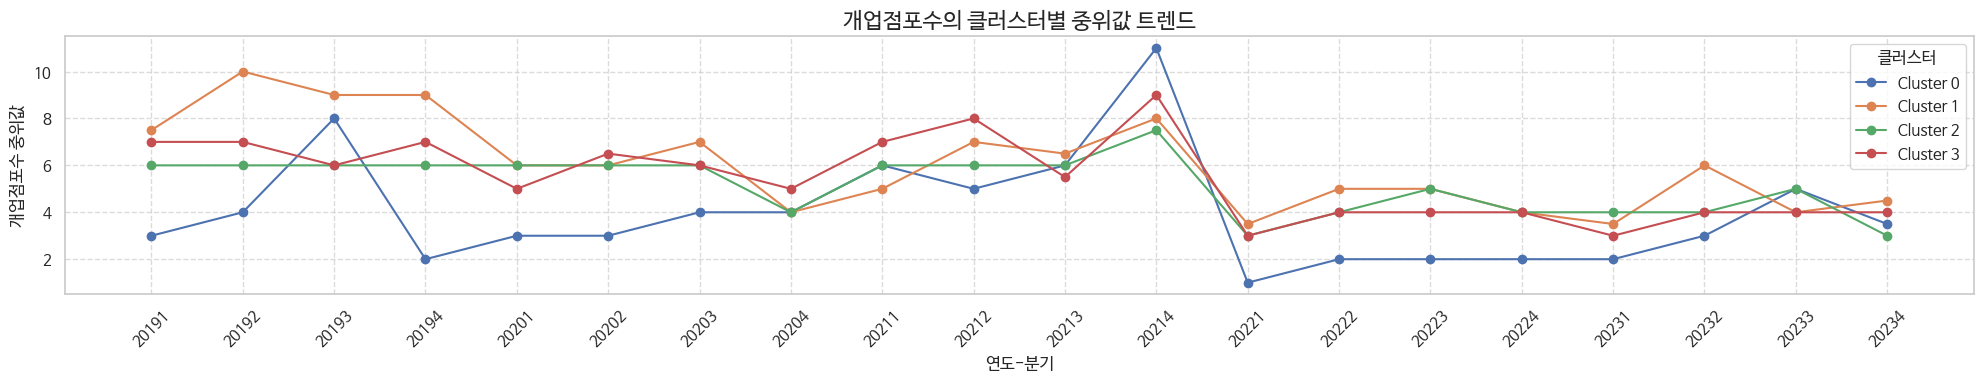

None

In [67]:
# 0번 군집 기준 총 직장인구가 많음 -> 임대료 높음 -> 주거보단 직장에 관한 케이스가 더 큰거같음.
display(help_me_median(target_df, '1층임대료'))
display(help_me_median(target_df, '연령대50직장인구수'))
display(help_me_median(target_df, '개업점포수'))